In [1438]:
from collections import defaultdict
import random

from tqdm.notebook import tqdm

import pandas as pd
from collections import Counter

from scipy import sparse
from scipy.sparse.linalg import svds
import numpy as np

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from nltk.tokenize import sent_tokenize, word_tokenize, regexp_tokenize

import glob
import re
import matplotlib.pyplot as plt
import seaborn as sns

import math
from statistics import *

In [43]:
def create_book_dictionary(book_folder_name):
    glob_name = book_folder_name + '/*'
    books_in_folder = glob.glob(glob_name)
    book_path = book_folder_name + '\\'
    
    dict_name = {}
    all_book = ""
    book_name_start = len(book_path)
    
    for b in books_in_folder:
        book = b[book_name_start:]
        with open(book_path+book,encoding="utf8") as fi:
            book_r = fi.read()
        start_b = re.search(r"\*\*\*[^\*]+\*\*\*",book_r)
        end = start_b.end()
        try_book = book_r[end:]
        end_b = re.search(r"\*\*\*[^\*]+\*\*\*",try_book)
        cut_off = end_b.start()
        complete_b = try_book[:cut_off]
        c_book = complete_b.replace('\n', ' ')
        book_name = book[:-4]
        dict_name[book_name] = c_book
    return dict_name

In [318]:
def voynich_cleaner():
    book_folder_name = 'manuscript_text'
    glob_name = book_folder_name + '/*'
    books_in_folder = glob.glob(glob_name)
    book_path = book_folder_name + '\\'

    dict_name = {}
    all_book = ""
    book_name_start = len(book_path)
    
    for b in books_in_folder:
        book = b[book_name_start:]
        with open(book_path+book,encoding="utf8") as fi:
            book_r = fi.read()
        c_book = re.sub(r'\#[^\n]+\n', '',book_r)
        m_book = re.sub(r'\|[^|]*\)', '',c_book)
        f_book = re.sub(r'\(', '',m_book)
        p_book = re.sub(r'[_]{4,}', '',f_book)
        #c_book = re.sub(r'\#', '',book_r)
        #c_book_repalced = c_book.replace(r',', ' ')
        book_name = book[:-4]
        dict_name[book_name] = p_book
    return(dict_name)

In [44]:
def create_common_df(max_word_count, book_dictionary):
    column_name_list = list((range(1, max_word_count + 1)))
    
    log_name_list = []
    for r in column_log_list:
        log_name_list.append(math.log(r))
        
    cmn_word_df = pd.DataFrame(columns=column_name_list)
    cmn_word_df.loc[0,:] = log_name_list
    
    count = 0
    book_index = []
    for b in book_dictionary:
        word_rank = 0 
        false_word = ['s','t','n','5','10','15','20']
        ind = []
        fre = []
        fretwo = []
        run = 1
        book_token_words = [x.lower() for x in regexp_tokenize(book_dictionary[b], '\w+')]
        if len(book_token_words) > 9999:
            book_index.append(b)
            book_token_counter = Counter(book_token_words).most_common(max_word_count+20)
            max_fre = 0
            for item in book_token_counter:
                if item[0] not in false_word:
                    if word_rank < max_word_count:
                        ind.append(item[0])
                        fre.append(item[1])
                        fretwo.append(math.log(item[1]))
                        if (item[1]*run) > max_fre:
                            max_fre = item[1]*run
                        run = run + 1
                        word_rank = word_rank + 1
            cmn_word_df.loc[count+1,:] = fretwo
            count = count + 1
            print(b)
            print(book_token_counter)
    return(cmn_word_df)

In [45]:
def pfit_slope(fit_df):
    form_fit_df = fit_df.apply(pd.to_numeric)
    count = 0
    for row in fit_df.iterrows():
        if count != 0:
            theta = np.polyfit(form_fit_df.loc[0,:], form_fit_df.loc[count,:], 1)
            print("{} slope".format(theta[0]))
        count = count + 1

In [46]:
def full_book_dictionary(book_folder_name):
    glob_name = book_folder_name + '/*'
    books_in_folder = glob.glob(glob_name)
    book_path = book_folder_name + '\\'
    
    dict_name = {}
    all_book = ""
    book_name_start = len(book_path)
    
    for b in books_in_folder:
        book = b[book_name_start:]
        with open(book_path+book,encoding="utf8") as fi:
            book_r = fi.read()
        c_book = book_r.replace('\n', ' ')
        book_name = book[:-4]
        dict_name[book_name] = c_book
    return dict_name

In [1588]:
def full_common_df(book_dictionary):
    column_name_list = list((range(1, 90000 + 1)))
    
    log_name_list = []
    for r in column_name_list:
        #exp_rank_num = z_law_math(r)
        exp_rank_num = (((r+2.7)**1.0))
        #log_name_list.append(exp_rank_num)
        log_name_list.append(math.log(exp_rank_num,2.7))
        #log_name_list.append(math.log(r))
    
    column_name = ['rank_log']
    cmn_word_df = pd.DataFrame(columns=column_name)
    cmn_word_df['rank_log']= log_name_list
    #cmn_word_df.loc[0,:] = log_name_list
    
    count = 0
    book_index = []
    for b in book_dictionary:
        word_rank = 0 
        false_word = ['s','t','n','5','10','15','20']
        ind = []
        fre = []
        fretwo = []
        book_df_header = [b]
        single_book_df = pd.DataFrame(columns=book_df_header)
        run = 1
        book_token_words = [x.lower() for x in regexp_tokenize(book_dictionary[b], '\w+')]
        book_total_words = len(book_token_words)
        if len(book_token_words) > 0:
            book_index.append(b)
            book_token_counter = Counter(book_token_words).most_common()
            max_fre = 0
            for item in book_token_counter:
                if item[0] not in false_word:
                    ind.append(item[0])
                    fre.append(item[1])
                    exp_rank_num = item[1] / book_total_words
                    #exp_rank_num = item[1] * z_law_math()
                    #fretwo.append(math.log(exp_rank_num))
                    #exp_rank_num = item[1]
                    fretwo.append(math.log(exp_rank_num,2.7))
                    if (item[1]*run) > max_fre:
                        max_fre = item[1]*run
                    run = run + 1
                    word_rank = word_rank + 1
            single_book_df[b] = fretwo
            cmn_word_df = pd.concat([cmn_word_df,single_book_df], axis=1)
            #cmn_word_df.loc[count+1,:] = fretwo
            count = count + 1
    return(cmn_word_df)

In [366]:
def dictionary_to_token(b_dictionary):
    
    token_d = {}
    
    for b in b_dictionary:
        token_for_book = [x.lower() for x in regexp_tokenize(b_dictionary[b], '\w+')]
        token_d[b] = token_for_book
    
    return(token_d)

In [367]:
def ranked_dictionary(token_d):
    
    r_dictionary = {}
    
    for t in token_d:
        counted = Counter(token_d[t]).most_common()
        r_dictionary[t] = counted
    
    return(r_dictionary)

In [ ]:
def rank_list(token_d):
    
    r_dictionary = {}
    
    for t in token_d:
        counted = Counter(token_d[t]).most_common()
        r_dictionary[t] = counted
    
    return(r_dictionary)

In [953]:
def new_common_df(book_dictionary, max_word = 30000):
    column_name_list = list((range(1, max_word + 1)))
    
    log_name_list = []
    for r in column_name_list:
        #exp_rank_num = z_law_math(r)
        exp_rank_num = (((r+2.7)**1.1))
        #log_name_list.append(exp_rank_num)
        log_name_list.append(math.log(exp_rank_num,2.7))
    
    column_name = ['rank_log']
    cmn_word_df = pd.DataFrame(columns=column_name)
    cmn_word_df['rank_log']= log_name_list
    count = 0
    book_index = []
    false_word = ['s','t','n','5','10','15','20']
    
    for b in book_dictionary:
        word_rank = 0 
        fretwo = []
        book_df_header = [b]
        single_book_df = pd.DataFrame(columns=book_df_header)
        run = 1
        book_token_words = [x.lower() for x in regexp_tokenize(book_dictionary[b], '\w+')]
        book_total_words = len(book_token_words)
        if len(book_token_words) > 0:
            book_index.append(b)
            book_token_counter = Counter(book_token_words).most_common()
            total_words = len(book_token_counter)
            max_fre = 0
            
            for item in book_token_counter:
                if item[0] not in false_word:
                    if word_rank < total_words:
                        exp_rank_num = item[1] / book_total_words
                        #exp_rank_num = item[1] 
                        #exp_rank_num = item[1] * math.log()
                        #fretwo.append(math.log(exp_rank_num))
                        #fretwo.append(z_law_math(item[1]))
                        fretwo.append(math.log(exp_rank_num,2.7))
                        if (item[1]*run) > max_fre:
                            max_fre = item[1]*run
                        run = run + 1
                        word_rank = word_rank + 1
                else:
                    total_words = total_words - 1
            single_book_df[b] = fretwo
            cmn_word_df = pd.concat([cmn_word_df,single_book_df], axis=1)
            count = count + 1
    return(cmn_word_df)

In [241]:
def tokenize_dictionary(book_text_d):
    
    book_tokenized_dictionary = {}
    
    for b in book_text_d:
        book_tokenized = regexp_tokenize(book_text_d[b], '\w+')
        if len(book_tokenized) > 0:
            book_tokenized_dictionary[b] = book_tokenized
    return(book_tokenized_dictionary)

In [928]:
def new_slope(fit_df, book_text_d, graph_check = "no", graph_label = "None"):
    form_fit_df = fit_df.apply(pd.to_numeric)
    count = 0
    if graph_check == "yes":
        for col in fit_df.columns:
            if count == 1:
                form_fit_df = form_fit_df.drop_duplicates(subset=[col], keep='last')
                print(form_fit_df)
            count = count + 1
    count = 0
    form_fit_df = fit_df
    for col in fit_df.columns:
        row_len = form_fit_df[col].count() -1
        if count != 0:
            #total_words = len(regexp_tokenize(book_text_d[col], '\w+'))
            total_words = fit_df[col].sum()
            #theta= np.polyfit(form_fit_df.iloc[:row_len,0], form_fit_df.iloc[:row_len,count], 1)
            theta = np.polyfit(form_fit_df.iloc[:row_len,count], form_fit_df.iloc[:row_len,0], 1)
            if graph_check == "yes":
                plt.scatter(form_fit_df.iloc[:,0], form_fit_df.iloc[:,count], alpha=.5)
                #plt.plot(theta, alpha)
                #plt.plot(fit_df.iloc[:,0], 8 -1* fit_df.iloc[:,0], '-')
                plt.xlabel("Word Rank (Log base e)",size=14)
                plt.ylabel("Word Frequency (Log base e)",size=14)
                #plt.plot(x, b + m * x, '-')
                plt.title(graph_label,size=14)
                #plt.show()
                print("{} slope on {} unique words and {} total words for {}".format(theta[0],row_len,total_words,col))
            else:
                #plt.scatter(fit_df.iloc[:,0], fit_df.iloc[:,count], alpha=.5)
                #theta = np.polyfit(form_fit_df.iloc[:row_len,0], form_fit_df.iloc[:row_len,count], 1)
                theta = np.polyfit(form_fit_df.iloc[:row_len,count], form_fit_df.iloc[:row_len,0], 1)
                #plt.plot(theta, alpha)
                #plt.show()
                print("{} slope on {} unique words and {} total words for {}".format(theta[0],row_len,total_words,col))
        count = count + 1

In [243]:
def plot_df(log_df):
    plt.rcParams["figure.figsize"] = [15, 10]
    count = 0
    for col in log_df.columns:
        if count != 0:
            plt.scatter(log_df.iloc[:,0], log_df.iloc[:,count], alpha=.5)
        count = count + 1

In [799]:
def zipf_df(token_numbers,word_counts_df):
    total_words = len(token_numbers)
    
    column_name_list = list((range(1, 90000 + 1)))
    
    log_name_list = []
    for r in column_name_list:
        #exp_rank_num = z_law_math(r)
        #exp_rank_num = (1/((r+1)**1))
        #log_name_list.append(math.log(exp_rank_num))
        exp_rank_num = (((r+2.7)**1.1))
        log_name_list.append(math.log(exp_rank_num,2.7))
    
    column_name = ['rank_log']
    exp_word_df = pd.DataFrame(columns=column_name)
    exp_word_df['rank_log']= log_name_list
    
    for b in token_numbers:
        total_u_words = word_counts_df[b].count()
        total_words = len(token_numbers[b])
        #total_words = total_u_words
        total_u_words = word_counts_df[b].count()
        book_exp_list = []
        top_word = Counter(token_numbers[b]).most_common(1)[0]
        print(top_word)
        book_df_header = [b]
        single_book_df = pd.DataFrame(columns=book_df_header)
    
        for x in range(total_u_words):
            exp_rank_num = z_law_math(x)
            exp_r_n = (total_words*exp_rank_num)
            #exp_rank_num = total_words * (1/((x+2.7)**1))
            #book_exp_list.append(math.log(exp_rank_num))
            #book_exp_list.append((exp_rank_num))
            #book_exp_list.append(math.log(x+1))
            #fretwo.append(math.log(exp_rank_num,2.7))
            book_exp_list.append(math.log(exp_r_n,2.7)-2)
        #single_book_df[b] = book_exp_list[::-1]
        single_book_df[b] = book_exp_list
        exp_word_df = pd.concat([exp_word_df,single_book_df], axis=1)
    return(exp_word_df)

In [929]:
def plot_exp_df(log_df, exp_df):
    plt.rcParams["figure.figsize"] = [12, 8]
    count = 0
    for col in log_df.columns:
        if count == 1:
            log_df = log_df.drop_duplicates(subset=[col], keep='last')
        count = count + 1
    max_row = log_df.iloc[:,1].count()
    print(max_row)
    count = 0
    for col in log_df.columns:
        if count != 0:
            #plt.scatter(log_df.iloc[:,count]*-1, log_df.iloc[:,0], alpha=.5)
            plt.scatter(log_df.iloc[:,0], log_df.iloc[:,count], alpha=.5)
            #plt.scatter(log_df.iloc[:,count], log_df.iloc[:,0], alpha=.5)
            max_exp_row = exp_df.iloc[:,1].count()
            plt.plot(exp_df.iloc[:max_exp_row,0], exp_df.iloc[:max_exp_row,count], color='black', linestyle='--', alpha=1, linewidth=2)
            #plt.scatter(fit_df.iloc[:,0], fit_df.iloc[:,count], alpha=.5)
            theta, alpha = np.polyfit(log_df.iloc[:max_row,0], log_df.iloc[:max_row,count], 1)
            print(theta)
            plt.plot(log_df.iloc[:max_row,0], alpha + theta * log_df.iloc[:max_row,0], '-', color='black')
            #plt.plot(theta, alpha)
            #plt.plot(exp_df.iloc[:,0], 8 -1* exp_df.iloc[:,0], '-')
            plt.xlabel("Log Word Rank (Log base e)")
            plt.ylabel("Log Word Prob Frequency (Log base e)")
            #plt.ylim([-1, 10])
            #plt.scatter(exp_df.iloc[:,count], exp_df.iloc[:,0], alpha=.5)
            plt.show()
        count = count + 1

In [797]:
def combine_books(token_d):
    
    all_words = []
    
    for b in token_d:
        all_words.extend(token_d[b])
    
    return(all_words)

In [342]:
def combine_books_dictionary(indiv_books, string_name_d):
    
    all_book_dictionary = {}
    all_words = ""
    
    for b in indiv_books:
        all_words = all_words + indiv_books[b]
    
    all_book_dictionary[string_name_d] = all_words
    
    return(all_book_dictionary)

In [794]:
def z_law_math(num_check):
    z_result = (1/((num_check+1)**1.0))
    return(z_result)

In [344]:
def bar_top_words(b_d):
    for b in b_d:
        f_text = b_d[b]
        
        print_check = 10
        to_book = regexp_tokenize(f_text, '\w+')
        book_token_counter = Counter(to_book).most_common()
        total_words = len(book_token_counter)
        s_count = 0
        x_list = []
        y_list = []
        
        for item in book_token_counter:
            if s_count < print_check:
                x_list.append(item[0])
                y_list.append(item[1])
                s_count = s_count + 1
        plt.bar(x_list,y_list)
        plt.show()

In [754]:
def random_corpus(complete_text, book_alone, sim_amount = 100):
    #total_words = len(full_words)
    random_rank_d = {}
    
    for c in complete_text:
        
        column_name_list = list((range(1, sim_amount + 1)))
    
        rand_name_list = []
        for r in column_name_list:
            rand_name_list.append(r)
        
        total_words = len(complete_text[c])
        to_book = [x.lower() for x in regexp_tokenize(book_alone[c], '\w+')]
        book_token_counter = Counter(to_book).most_common()
        rank_numbers = [x[1]/total_words for x in book_token_counter]
        rank_words = [x[0] for x in book_token_counter]
        
        total_words = len(complete_text[c])
        total_u_words = len(book_token_counter)
        rank_column = list((range(1, total_u_words + 1)))
        rand_df = pd.DataFrame(rank_column)
        
        for i in range(sim_amount):
            random_words = np.random.multinomial(total_words, rank_numbers, size=1).tolist()[0]
            l_random_words = []
            for x in random_words:
                if x != 0:
                    rand_calc = math.log(x,2.7)
                else:
                    rand_calc = 0
                l_random_words.append(rand_calc)
            #random_words_odds = [math.log((x+.001) / total_words) for x in random_words]
            #exp_rank_num = z_law_math(x,2.7)
            #random_words_odds = math.log(random_words/total_words)
            #random_words_odds = random_words
            #rand_df[i+1] = pd.Series(sorted(random_words))
            #sorted_rand = pd.Series(sorted(l_random_words,reverse=True))
            sorted_rand = pd.Series(l_random_words)
            sorted_df = pd.DataFrame(sorted_rand)
            rand_df = pd.concat([rand_df,sorted_df], axis=1)
            #new_array = np.column_stack((rank_words, random_words[0]))
        
        random_rank_d[c] = rand_df
    return(random_rank_d)

In [509]:
def dictionary_ranking(freq_dict):
    
    start_dict = {}
    
    for d in freq_dict:
        current_df = freq_dict[d]
        count = 0
        start_df = pd.DataFrame()
        for col in current_df.columns:
            rows = current_df.iloc[:,count].count()
            r_values = []
            for x in range(rows):
                new_val = current_df.iloc[x,count]
                if new_val == 0:
                    app_value = 0
                else:
                    app_value = math.log(new_val)
                r_values.append(app_value)
            count = count + 1
            freq_adj_df = pd.DataFrame(r_values)
            start_df = pd.concat([start_df,freq_adj_df], axis=1)
        start_dict[d] = start_df
    return(start_dict)

In [437]:
def array_dictionary(book_dictionary):
    book_numpy_array = {}
    
    for b in book_dictionary:
        book_token_word = [x.lower() for x in regexp_tokenize(book_dictionary[b], '\w+')]
        book_numpy_array[b] = numpy.array(book_token_word)
    return (book_numpy_array)

In [438]:
def word_location(token_occurance_d,book_array):
    for b in token_occurance_d:
        

SyntaxError: unexpected EOF while parsing (96650444.py, line 3)

In [930]:
def plot_rand(log_df, exp_df, p_title = "None"):
    plt.rcParams["figure.figsize"] = [12, 8]
    count = 0
    max_list = []
    min_list = []
    max_row = log_df.iloc[:,1].count()
    ex_max_row = t_df.iloc[:,1].count()
    print(max_row)
    for col in exp_df.columns:
        if count != 0:
            if count == 1:
                freq_col = log_df.iloc[:max_row,count]
                rank_col = log_df.iloc[:max_row,0]
                log_con_df = pd.concat([rank_col, freq_col], axis=1)
                log_col_name = log_con_df.columns[1]
                drop_log_df = log_con_df.drop_duplicates(subset=[log_col_name], keep='first')
                drop_predict = drop_log_df
                predict_max = drop_log_df.iloc[:,1].count()
                drop_log_df = log_con_df
                drop_max_count = drop_log_df.iloc[:,1].count()
                plt.scatter(drop_log_df.iloc[:drop_max_count,0], drop_log_df.iloc[:drop_max_count,1], alpha=.5)
                #plt.plot(exp_df.iloc[:max_row,0], exp_df.iloc[:max_row,count], color='black', linestyle='--', alpha=1, linewidth=2)
                theta, alpha = np.polyfit(drop_predict.iloc[:predict_max,0], drop_predict.iloc[:predict_max,1], 1)
                print(theta)
                plt.plot(drop_predict.iloc[:predict_max,0], alpha + theta * drop_predict.iloc[:predict_max,0], '-', color='black')
                plt.xlabel("Log Word Rank (Log base e)", size=14)
                plt.ylabel("Log Word Prob Frequency (Log base e)",size=14)
            else:
                new_max_count = exp_df.iloc[:,count].count()
                exp_col = exp_df.iloc[:new_max_count,count]
                log_col = log_df.iloc[:new_max_count,0]
                exp_log_df = pd.concat([log_col, exp_col], axis=1)
                sub_col_name = exp_log_df.columns[1]
                if (count % 2) == 0:
                    drop_el_df = exp_log_df.drop_duplicates(subset=[sub_col_name], keep='first')
                else:
                    drop_el_df = exp_log_df.drop_duplicates(subset=[sub_col_name], keep='last')
                #drop_el_df = exp_log_df
                drop_max_count = drop_el_df.iloc[:,1].count()
                theta, alpha = np.polyfit(drop_el_df.iloc[:drop_max_count-1,0], drop_el_df.iloc[:drop_max_count-1,1], 1)
                plt.plot(log_df.iloc[:max_row,0], alpha + theta * log_df.iloc[:max_row,0], '-', color='red', alpha = .2)
                plt.scatter(drop_el_df.iloc[:drop_max_count,0], drop_el_df.iloc[:drop_max_count,1], alpha=.01, color = 'red')
                if (count % 2) == 0:
                    max_list.append(theta)
                else:
                    min_list.append(theta)
        count = count + 1
    #plt.legend(['Text Results', 'Estimated Line of Best Fit', 'Random Draw'],loc="upper right")
    plt.title(p_title,size=14)
    plt.show()
    max_check = mean(max_list)
    min_check = mean(min_list)
    print(max_check)
    print(min_check)

In [1107]:
def topic_calc(rank_dict, all_text, words_list):
    total_u_words = len(rank_dict)
    total_words = len(words_list)
    count = 0 
    two_start_end = []
    for x in rank_dict:
        if x[1] == 2:
            if len(two_start_end) < 1:
                two_start_end.append(count)
        if x[1] == 1:
            two_start_end.append(count)
            break
        count = count + 1
    rare_words = []
    total_rare = two_start_end[1] - two_start_end[0]
    for x in range(total_rare):
        rare_words.append(rank_dict[count-x-1][0])
    rev_text = words_list[::-1]
    avg_dist = []
    plot_count = 0
    for r in rare_words:
        #print(r)
        first_app = words_list.index(r)
        last_app = len(words_list) - 1 - rev_text.index(r)
        topic_dist = last_app - first_app
        dist_per = topic_dist/total_words
        avg_dist.append(dist_per)
        y_track=[last_app]
        x_track=[first_app]
        hist_list = []
        plt.scatter(x_track,y_track)
        plot_count = plot_count + 1
    print(np.mean(dist_per))
    plt.show()

In [1627]:
def topic_book(book_text,page_length = 300):
    book_token_words = [x.lower() for x in regexp_tokenize(book_text, '\w+')]
    book_total_words = len(book_token_words)
    print(book_total_words)

    book_token_counter = Counter(book_token_words).most_common()
    total_u_words = len(book_token_counter)
    
    total_words = len(book_token_words)
    pages = int(total_words/page_length)
    if total_words < 300:
        print("Low words")
        pages = 20
    page_list = []
    for x in range(pages):
        slice_num = x*page_length 
        page_list.append(book_token_words[slice_num:slice_num + page_length])
    
    space = " "
    page_list = [space.join(p) for p in page_list]
    
    countvectorizer = CountVectorizer()
    page_vector = countvectorizer.fit_transform(page_list)
    
    best_component = 0
    best_plex = 100000
    for x in range(10):
        lda_fit = LatentDirichletAllocation(n_components = x + 3).fit(page_vector)
        current_plex = lda_fit.perplexity(page_vector)
        if current_plex < best_plex:
            best_plex = current_plex
            best_component =  x + 3
    
    lda_fit = LatentDirichletAllocation(n_components = best_component).fit(page_vector)
    
    topic = 1
    topic_df = pd.DataFrame({
        'word':countvectorizer.get_feature_names_out(),
        'probability':lda_fit.components_[topic]/lda_fit.components_.sum(axis=1)[topic]
    })
    
    #print(topic_df.sort_values('probability',ascending = False).head(20))
    lda_p_df = pd.DataFrame(lda_fit.transform(page_vector))
    #print("Document Score")
    doc_score = np.abs(lda_p_df.diff()).sum(axis=1).mean()
    #print(np.abs(lda_p_df.diff()).sum(axis=1).mean())
    
    return_list = []
    return_list.append(doc_score)
    track_score = []
    track_actual = []
    track_actual.append(doc_score)
    for x in range(1000):
        rand_df = lda_p_df.copy()

        rand_index = rand_df.index.tolist()
        np.random.shuffle(rand_index)

        rand_df = rand_df.loc[rand_index]

        track_score.append(np.abs(rand_df.diff()).sum(axis=1).mean())
    
    #print(np.mean(track_score))
    return_list.append(np.mean(track_score))
    return_list.append(np.min(track_score))
    track_actual.append([track_score])
    #print("Best Random Score was {}".format(np.min(track_score)))
    #if(np.min(track_score) < doc_score):
        #print("BETTER SCORE")
    #plt.hist(track_score)
    #plt.show()
    #return(return_list)
    #return(track_score)
    return(track_actual)

In [1659]:
def multi_book_topic(corpus):
    num_of_books = len(corpus)
    #plt.subplots(1, 1, figsize=(5, 10))
    plt.rcParams["figure.figsize"] = [15, 10]
    plt.rcParams.update({'font.size': 18})
    avg_diff = []
    min_amount = []
    book_list = []
    count_run = 0
    for c in corpus:
        if count_run < 2:
            print(c)
            topic_list_score = topic_book(corpus[c])
            #avg_diff.append(topic_list_score[1] - topic_list_score[0])
            #min_amount.append(topic_list_score[2])
            #book_list.append(c)
            #plt.subplot(44, 1, count_run + 1)
            plt.hist(topic_list_score[1], bins = 10, color = 'blue', label = "Shuffled Results")
            y, x, _ = plt.hist(topic_list_score[1], bins = 10)
            maxy = y.max()
            #maxy = np.max(topic_list_score[1])
            linex = (topic_list_score[0], topic_list_score[0])
            liney = (0 , maxy)
            plt.plot(linex, liney, linewidth=5, color = 'red', label = "Unshuffled Result")
            plt.xlabel("Average Page Topic Difference")
            plt.ylabel("Frequency")
            #t_list = ['Ciceros Orations','Meditationes de Prima Philosophia',
                      #'Odes and Epodes','The Aeneid']
            plt.title(c, loc='center', wrap=True)
            plt.show()
        count_run = count_run + 1
    #plt.scatter(avg_diff,min_amount)
    #book_num = len(book_list)
    #for i in range(book_num):
        #plt.annotate(book_list[i], (avg_diff[i], min_amount[i]))
    #plt.title('A Christmas Carol')
    #plt.legend(loc="upper right")Average Page Topic Difference
    #plt.show()

A Christmas Carol in Prose; Being a Ghost Story of Christmas by Charles Dickens
29253


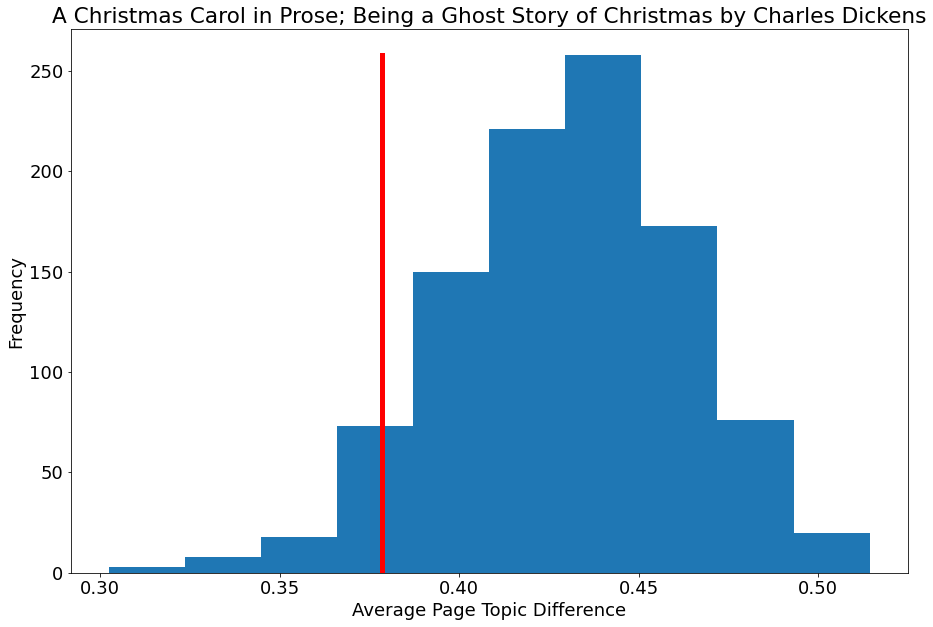

A Modest Proposal by Jonathan Swift
3431


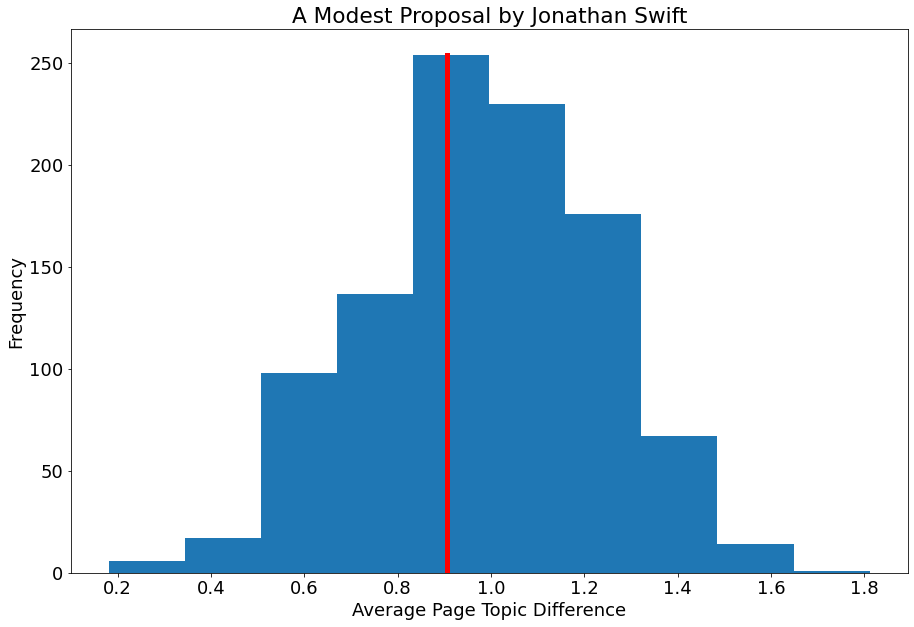

In [1660]:
multi_book_topic(e_book_d)

voynich_script


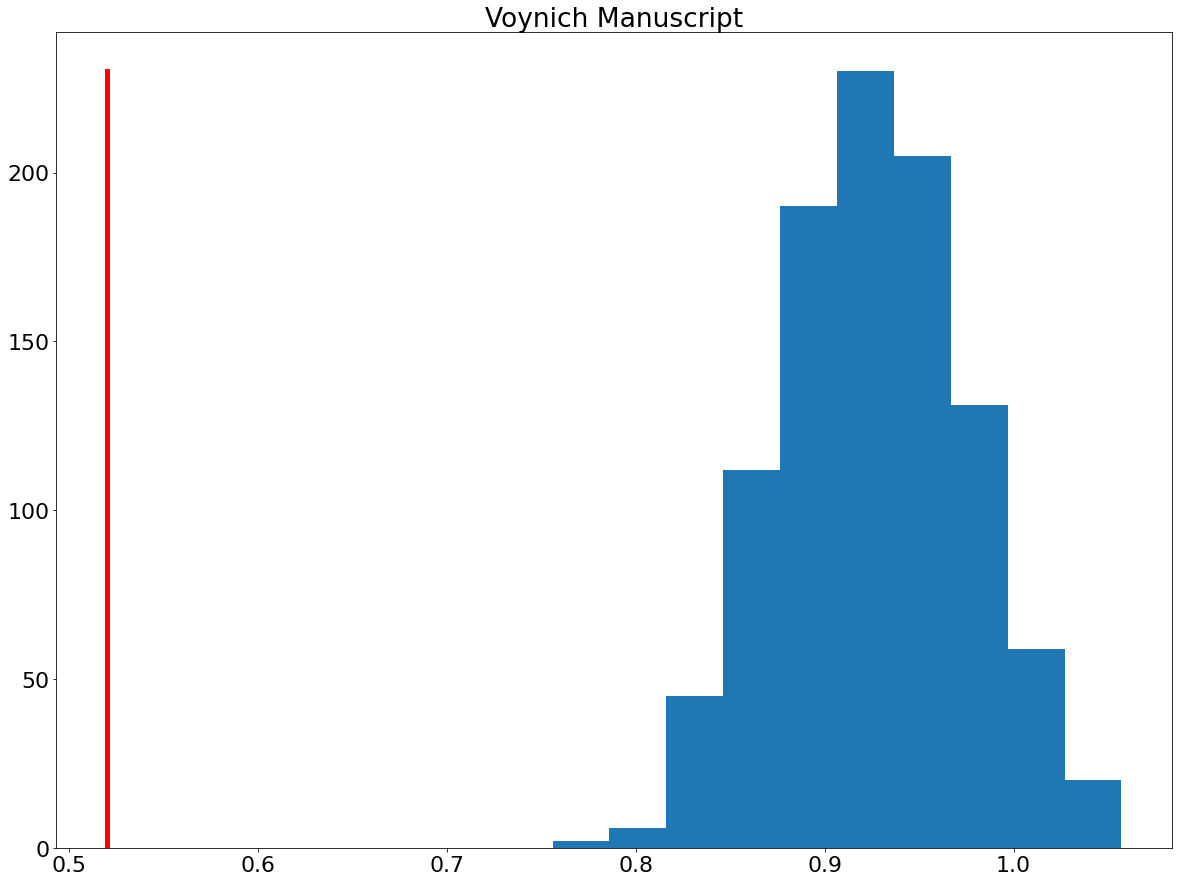

In [1549]:
multi_book_topic(manuscript_book_d)

Ciceros_Orations_by_Cicero
1.2752288717717843
Meditationes_de_prima_philosophia_by_René_Descartes
0.5337117449554681
Odes_and_Epodes_by_Horace
1.169673038312904
The_Aeneid_by_Virgil
0.991147302091482


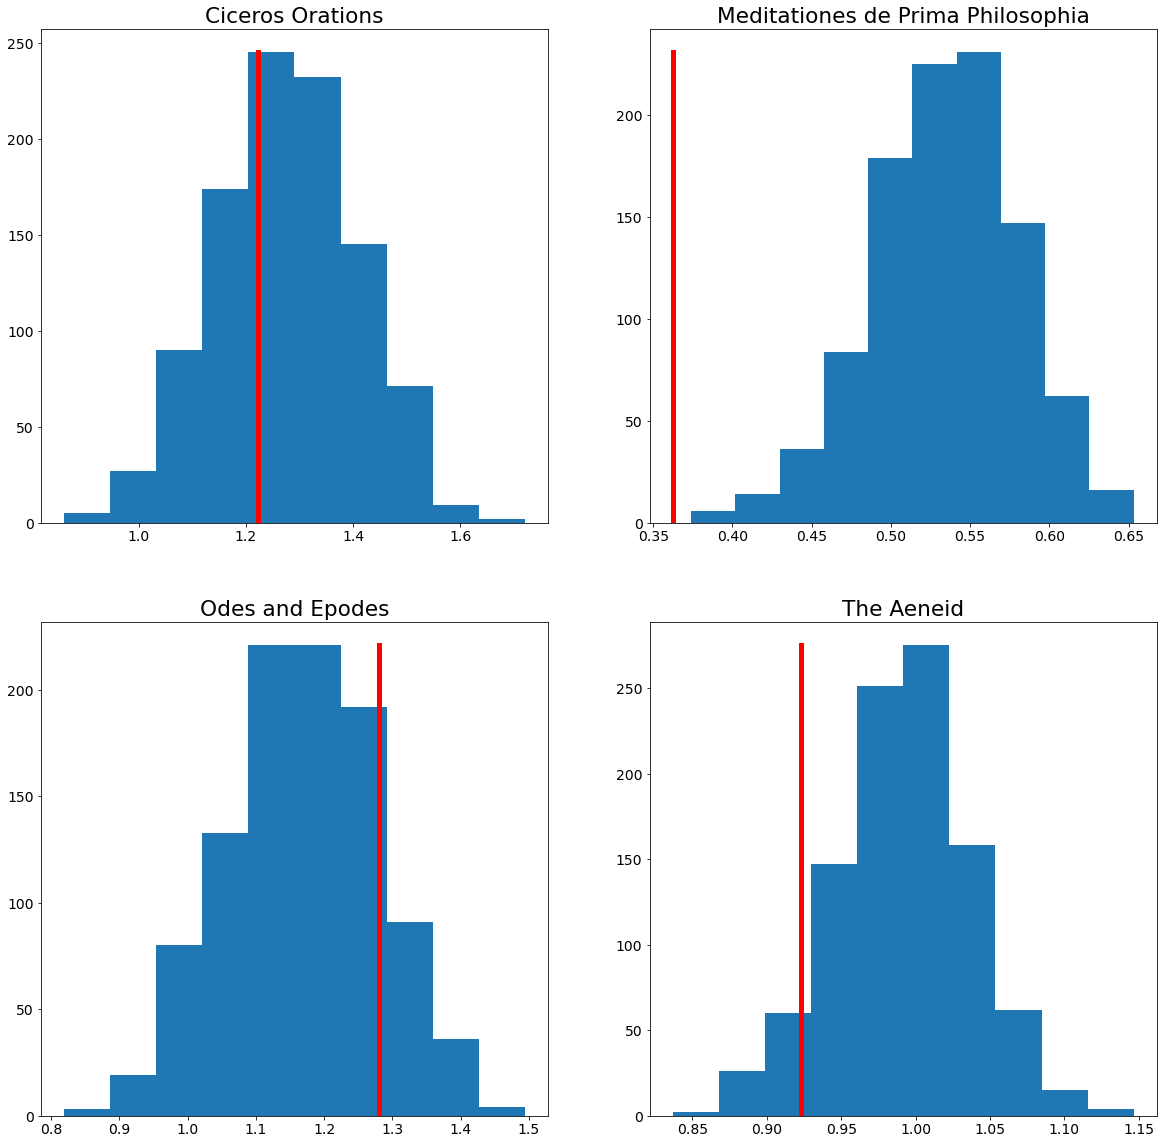

In [1586]:
l_book_d = create_book_dictionary('latin_books')
multi_book_topic(l_book_d)

Document Score
0.37978557291190623
0.658788552315267
Best Random Score was 0.5521176390548977


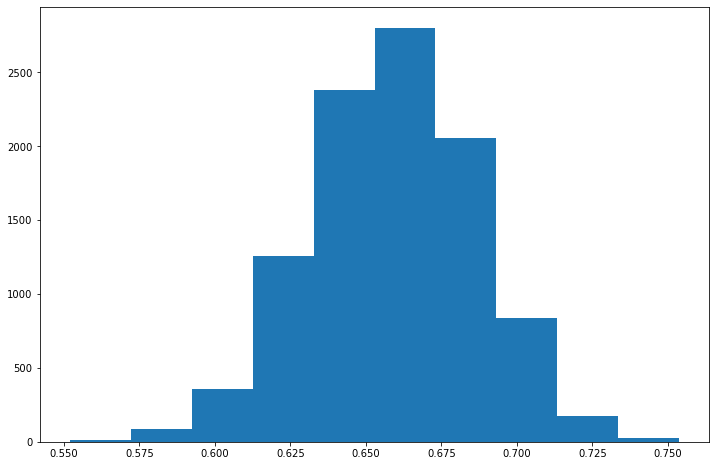

In [1370]:
topic_book(test_book)

In [1386]:
test_book = e_book_d['Adventures of Huckleberry Finn by Mark Twain']

In [1391]:
total_words = len(book_token_words)
pages = int(total_words/300)
page_list = []
for x in range(pages):
    slice_num = x*300
    page_list.append(book_token_words[slice_num:slice_num+300])

In [1392]:
space = " "
page_list = [space.join(p) for p in page_list]

In [1562]:
space = ' '
page_list[0]

'adventures of huckleberry finn tom sawyer s comrade by mark twain complete contents chapter i civilizing huck miss watson tom sawyer waits chapter ii the boys escape jim torn sawyer s gang deep laid plans chapter iii a good going over grace triumphant one of tom sawyers s lies chapter iv huck and the judge superstition chapter v huck s father the fond parent reform chapter vi he went for judge thatcher huck decided to leave political economy thrashing around chapter vii laying for him locked in the cabin sinking the body resting chapter viii sleeping in the woods raising the dead exploring the island finding jim jim s escape signs balum chapter ix the cave the floating house chapter x the find old hank bunker in disguise chapter xi huck and the woman the search prevarication going to goshen chapter xii slow navigation borrowing things boarding the wreck the plotters hunting for the boat chapter xiii escaping from the wreck the watchman sinking chapter xiv a general good time the harem

In [1273]:
countvectorizer = CountVectorizer()
page_vector = countvectorizer.fit_transform(page_list)

In [1337]:
lda_fit = LatentDirichletAllocation(n_components=3).fit(page_vector)

In [1379]:
print(lda_fit.perplexity(page_vector))

770.0486773899428


In [1380]:
#print(lda_fit.components_/lda_fit.components_.sum(axis=1))

print(lda_fit.components_[0,0]/lda_fit.components_.sum(axis=1)[0])
#print(lda_fit.components_[1,:])
#model.components_ / model.components_.sum(axis=1)[:, np.newaxis]

0.0001231879282401392


In [1344]:
topic = 2
topic_df = pd.DataFrame({
    'word':countvectorizer.get_feature_names_out(),
    'probability':lda_fit.components_[topic]/lda_fit.components_.sum(axis=1)[topic]
})

In [1345]:
topic_df.sort_values('probability',ascending = False).head(20)

,word,probability
6980,the,0.055118
367,and,0.029586
7094,to,0.026889
4761,of,0.026007
3635,in,0.017309
6979,that,0.017172
3839,it,0.017005
7874,you,0.014731
3344,he,0.014544
7588,was,0.013829


In [1315]:
lda_fit.transform(page_vector)[:,0][np.argsort(lda_fit.transform(page_vector)[:,0])]

array([0.00033557, 0.0003367 , 0.0003367 , 0.0003367 , 0.0003367 ,
       0.00033784, 0.00033899, 0.00034014, 0.00034014, 0.00034014,
       0.0003413 , 0.0003413 , 0.0003413 , 0.00034131, 0.00034247,
       0.00034247, 0.00034247, 0.00034247, 0.00034364, 0.00034364,
       0.00034364, 0.00034364, 0.00034364, 0.00034364, 0.00034364,
       0.00034365, 0.00034365, 0.00034483, 0.00034483, 0.00034483,
       0.00034483, 0.00034483, 0.00034483, 0.00034483, 0.00034483,
       0.00034483, 0.00034483, 0.00034484, 0.00034602, 0.00034602,
       0.00034602, 0.00034602, 0.00034602, 0.00034602, 0.00034602,
       0.00034602, 0.00034602, 0.00034602, 0.00034602, 0.00034602,
       0.00034602, 0.00034602, 0.00034602, 0.00034602, 0.00034602,
       0.00034602, 0.00034602, 0.00034602, 0.00034602, 0.00034603,
       0.00034603, 0.00034722, 0.00034722, 0.00034722, 0.00034722,
       0.00034722, 0.00034722, 0.00034722, 0.00034722, 0.00034722,
       0.00034722, 0.00034722, 0.00034722, 0.00034722, 0.00034

In [1306]:
np.argsort(lda_fit.transform(page_vector)[:,0])

array([135, 177, 174, 180, 133, 134, 140, 108, 109,  60, 175, 176, 137,
       172, 104, 160,  88,  90, 321,  85, 153, 152,  89, 173, 320,  31,
       125,  61,   5, 179, 263, 106,  32, 155,  86, 126, 124, 128, 259,
       138,   4,  92, 154, 167, 178, 215, 139,   9, 102, 267,  93,  87,
       159, 275, 122,  56,  91,  74, 115,  83, 105, 214, 101, 181, 257,
       127, 202,  82, 192,  57,  55, 274,  62, 255, 332, 248, 256, 331,
        52, 169,  12, 191, 213, 268, 185,  54, 261, 130, 316, 273, 171,
       119,   2, 170, 188, 129, 291,  45, 116, 250, 190,  78, 209, 193,
       253, 298, 301, 242, 146, 245, 182, 212, 229,   3, 266,  99, 258,
       349, 103,   7, 107, 164, 352, 189, 123,  22, 306, 197, 260, 111,
       131, 289, 114, 168, 309,   0, 143, 194, 136, 233, 235, 147,  33,
       281, 249,  94, 132, 183, 120,  13, 262,  77, 318, 290, 220, 196,
       187, 234, 238, 345,  17, 161, 144, 184, 110, 121, 149, 251, 279,
       195,  41,  84, 166,  95,  72,  39,   1, 198, 322, 296, 11

In [1307]:
lda_p_df = pd.DataFrame(lda_fit.transform(page_vector))

In [1308]:
np.abs(lda_p_df.diff()).sum(axis=1).mean()

0.37978557291190623

In [1309]:
track_score = []
for x in range(10000):
    rand_df = lda_p_df.copy()

    rand_index = rand_df.index.tolist()
    np.random.shuffle(rand_index)

    rand_df = rand_df.loc[rand_index]

    track_score.append(np.abs(rand_df.diff()).sum(axis=1).mean())

np.mean(track_score)

0.6584891019921252

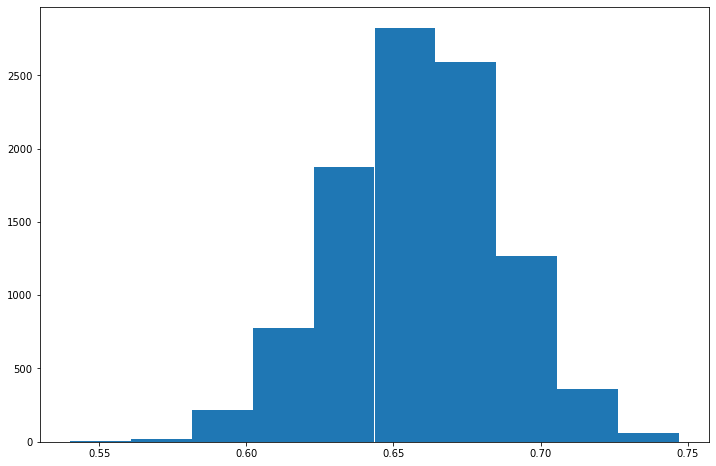

In [1310]:
plt.hist(track_score)
plt.show()

In [1284]:
np.min(track_score)

0.8195988620195767

In [1146]:
lda_fit.components_[topic]/lda_fit.components_.sum(axis=1)[topic]

array([3.32409694e-05, 3.32409694e-05, 3.32409694e-05, ...,
       3.32409694e-05, 3.32409695e-05, 3.32409694e-05])

In [1149]:
countvectorizer.vocabulary_

{'illustration': 13588,
 'ulysses': 27679,
 'by': 4406,
 'james': 14442,
 'joyce': 14675,
 'contents': 6320,
 'ii': 13551,
 '10': 2,
 '11': 8,
 '12': 13,
 '13': 16,
 '14': 18,
 '15': 20,
 'iii': 13553,
 '16': 24,
 '17': 26,
 '18': 29,
 'stately': 25175,
 'plump': 20085,
 'buck': 4177,
 'mulligan': 17594,
 'came': 4531,
 'from': 10987,
 'the': 26498,
 'stairhead': 25111,
 'bearing': 2850,
 'bowl': 3832,
 'of': 18463,
 'lather': 15267,
 'on': 18568,
 'which': 29147,
 'mirror': 17114,
 'and': 1660,
 'razor': 21538,
 'lay': 15319,
 'crossed': 6890,
 'yellow': 29722,
 'dressinggown': 8487,
 'ungirdled': 27868,
 'was': 28819,
 'sustained': 25913,
 'gently': 11361,
 'behind': 2985,
 'him': 12939,
 'mild': 17003,
 'morning': 17419,
 'air': 1358,
 'he': 12607,
 'held': 12743,
 'aloft': 1515,
 'intoned': 14216,
 '_introibo': 455,
 'ad': 1095,
 'altare': 1537,
 'dei_': 7513,
 'halted': 12352,
 'peered': 19404,
 'down': 8394,
 'dark': 7255,
 'winding': 29350,
 'stairs': 25112,
 'called': 4501,
 'o

In [1098]:
#print(book_token_words.index('thunder'))
print(book_token_words[2450:2500])

['you', 'and', 'i', 'may', 'confess', 'at', 'once', 'that', 'the', 'title', 'by', 'which', 'i', 'have', 'just', 'called', 'myself', 'is', 'not', 'exactly', 'my', 'own', 'i', 'was', 'aware', 'of', 'it', 'said', 'holmes', 'dryly', 'the', 'circumstances', 'are', 'of', 'great', 'delicacy', 'and', 'every', 'precaution', 'has', 'to', 'be', 'taken', 'to', 'quench', 'what', 'might', 'grow', 'to', 'be']


0.0648925191254623


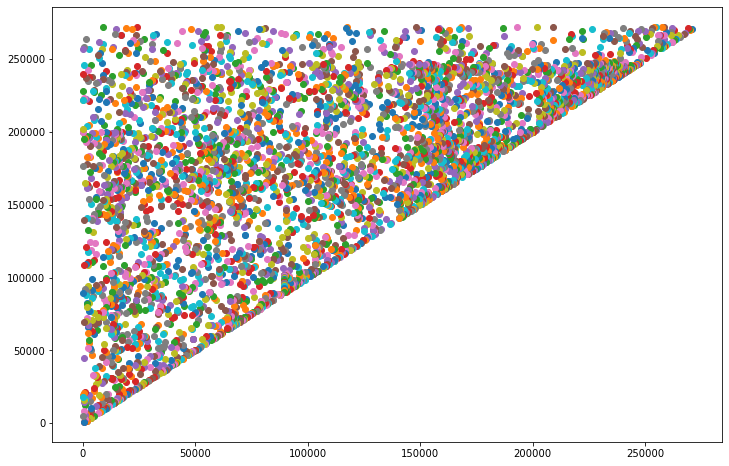

In [1108]:
topic_calc(book_token_counter,book_token_words,book_token_words)

In [1102]:
rand_list = []
runs = 10000
for r in range(runs): 
    x = random.uniform(0, 1)
    y = random.uniform(0, 1)
    distance = abs(x-y)
    rand_list.append(distance)
print(np.mean(rand_list))


0.334119575214858


In [1390]:
book_token_words = [x.lower() for x in regexp_tokenize(test_book, '\w+')]
book_total_words = len(book_token_words)

book_token_counter = Counter(book_token_words).most_common()
total_u_words = len(book_token_counter)

In [1086]:
for b in e_book_d:
    print(b)

A Christmas Carol in Prose; Being a Ghost Story of Christmas by Charles Dickens
A Modest Proposal by Jonathan Swift
A Tale of Two Cities by Charles Dickens
Adventures of Huckleberry Finn by Mark Twain
Anne of Green Gables by L. M.  Montgomery
Anthem by Ayn Rand
Dracula by Bram Stoker
Dubliners by James Joyce
Emma by Jane Austen
Frankenstein; Or, The Modern Prometheus by Mary Wollstonecraft Shelley
Great Expectations by Charles Dickens
Heart of Darkness by Joseph Conrad
Jane Eyre_ An Autobiography by Charlotte Brontë
Leviathan by Thomas Hobbes
Little Women by Louisa May Alcott
Metamorphosis by Franz Kafka
Moby Dick; Or, The Whale by Herman Melville
Narrative of the Life of Frederick Douglass, an American Slave by Frederick Douglass
Oliver Twist by Charles Dickens
Peter Pan by J. M.  Barrie
Pride and Prejudice by Jane Austen
Pygmalion by Bernard Shaw
Second Treatise of Government by John Locke
The Adventures of Sherlock Holmes by Arthur Conan Doyle
The Adventures of Tom Sawyer, Complete 

-1.0490422251967182
10.466573729784212


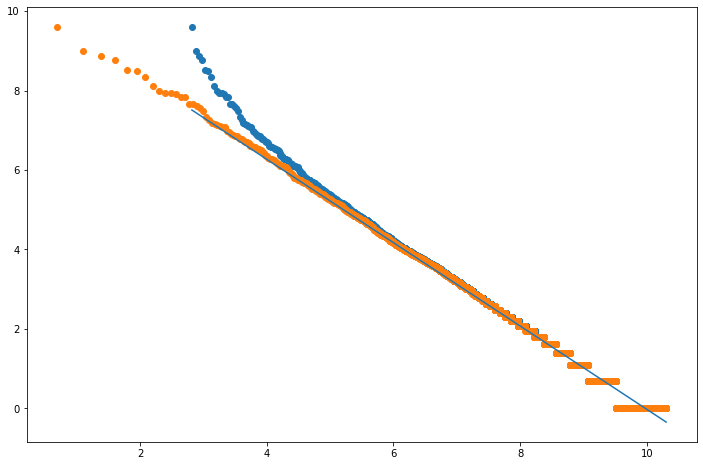

In [1110]:
#k
count = 1
y_list = []
x_list = []
try_list = []
for w in book_token_counter:
    z_number = w[1]
    y_list.append(math.log(z_number))
    x_list.append(math.log(count + 15.73))
    try_list.append(math.log(count + 1))
    count = count + 1
plt.scatter(x_list,y_list)
plt.scatter(try_list,y_list)
theta, alpha = np.polyfit(x_list,y_list, 1)
print(theta)
print(alpha)
plt.plot(np.array(x_list), alpha + theta * np.array(x_list))

plt.show()

        rank_log  all_english_books
0       1.448944          -2.953062
1       1.713884          -3.412601
2       1.927520          -3.622185
3       2.106534          -3.656202
4       2.260597          -3.861878
...          ...                ...
26352  11.273460         -13.956567
30738  11.443939         -14.246204
38575  11.695425         -14.654424
63347  12.244715         -15.352280
89999  12.633609                NaN

[1115 rows x 2 columns]


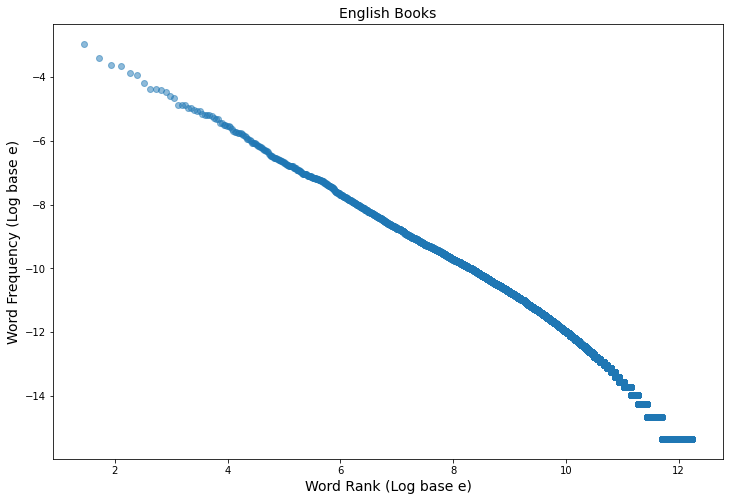

-0.664670390347787 slope on 63347 unique words and -883970.7163642403 total words for all_english_books
('the', 206884)
1114
-1.0490222508189335


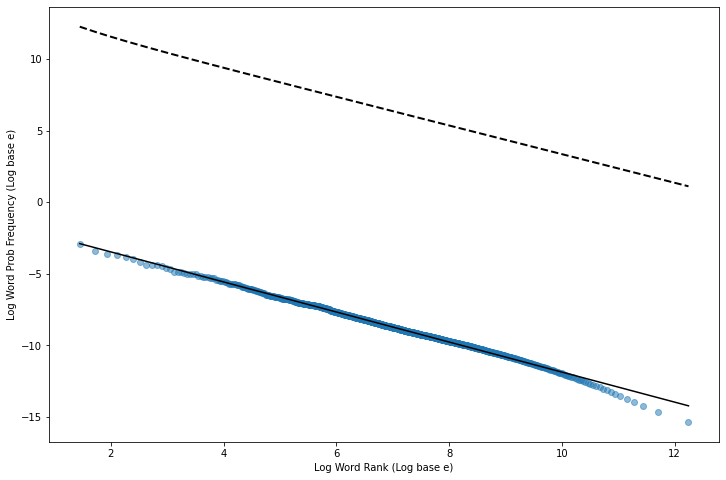

In [954]:
e_book_d = create_book_dictionary('english_books')
#e_book_df = new_common_df(e_book_d)
#new_slope(e_book_df, e_book_d)
#full_text = tokenize_dictionary(e_book_d)
combine_test = combine_books_dictionary(e_book_d, "all_english_books")
e_book_df = new_common_df(combine_test,90000)
new_slope(e_book_df, combine_test,"yes", "English Books")
full_text = tokenize_dictionary(combine_test)
expected_df = zipf_df(full_text,e_book_df)
plot_exp_df(e_book_df, expected_df)

In [908]:
e_book_df.head()
print(e_book_df.iloc[:,1].count())
print(np.polyfit(e_book_df.iloc[:63347,0], e_book_df.iloc[:63347,1], 1))
print(np.polyfit(e_book_df.iloc[:63347,1], e_book_df.iloc[:63347,0], 1))
print(e_book_df.iloc[:63347,1])
test_df = e_book_df.drop_duplicates(subset=None,keep='first')
print(test_df.iloc[:,1].count())
print(test_df.iloc[:63346,1])

63348
[-1.46299933 17.69267621]
[-0.66467039 12.0670635 ]
0        12.399218
1        11.939679
2        11.730095
3        11.696078
4        11.490402
           ...    
63342     0.000000
63343     0.000000
63344     0.000000
63345     0.000000
63346     0.000000
Name: all_english_books, Length: 63347, dtype: float64
63348
0        12.399218
1        11.939679
2        11.730095
3        11.696078
4        11.490402
           ...    
63341     0.000000
63342     0.000000
63343     0.000000
63344     0.000000
63345     0.000000
Name: all_english_books, Length: 63346, dtype: float64


In [932]:
e_book_d = create_book_dictionary('english_books')
justwords = dictionary_to_token(e_book_d)
r_dict = ranked_dictionary(justwords)

In [933]:
justwords = dictionary_to_token(combine_test)
r_dict = ranked_dictionary(justwords)
array_check = random_corpus(justwords, combine_test, 25)

63348
-1.0538872790134948


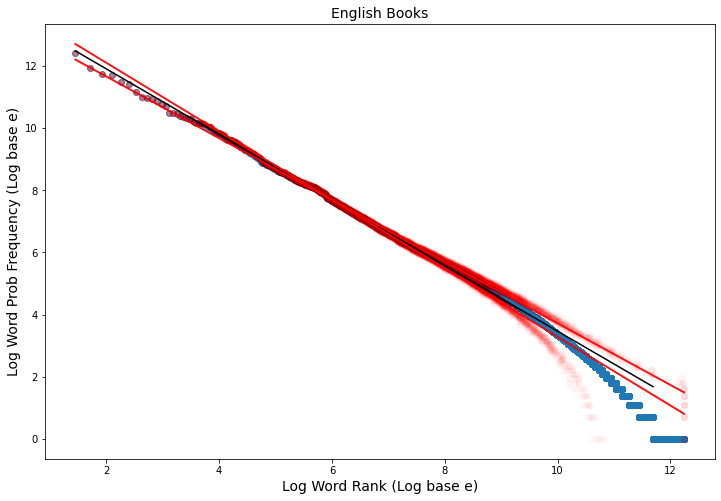

-1.101504316792521
-0.9915242576996433


In [934]:
plot_rand(e_book_df, array_check['all_english_books'],"English Books")

In [461]:
print(array_check['A Christmas Carol in Prose; Being a Ghost Story of Christmas by Charles Dickens'])

         0     0     0     0     0     0     0     0     0     0  ...     0  \
0        1  1555  1504  1608  1577  1615  1580  1583  1560  1509  ...  1529   
1        2  1102  1081  1014  1056  1013   937   970  1048  1124  ...  1119   
2        3   689   725   736   729   704   751   734   700   699  ...   700   
3        4   672   716   686   663   667   698   673   687   686  ...   669   
4        5   664   608   636   650   652   589   668   652   675  ...   663   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
4258  4259     0     0     0     0     0     0     0     0     0  ...     0   
4259  4260     0     0     0     0     0     0     0     0     0  ...     0   
4260  4261     0     0     0     0     0     0     0     0     0  ...     0   
4261  4262     0     0     0     0     0     0     0     0     0  ...     0   
4262  4263     0     0     0     0     0     0     0     0     0  ...     0   

         0     0     0     0     0     0     0     

In [385]:
print(justwords['A Christmas Carol in Prose; Being a Ghost Story of Christmas by Charles Dickens'])

['a', 'christmas', 'carol', 'in', 'prose', 'being', 'a', 'ghost', 'story', 'of', 'christmas', 'by', 'charles', 'dickens', 'preface', 'i', 'have', 'endeavoured', 'in', 'this', 'ghostly', 'little', 'book', 'to', 'raise', 'the', 'ghost', 'of', 'an', 'idea', 'which', 'shall', 'not', 'put', 'my', 'readers', 'out', 'of', 'humour', 'with', 'themselves', 'with', 'each', 'other', 'with', 'the', 'season', 'or', 'with', 'me', 'may', 'it', 'haunt', 'their', 'houses', 'pleasantly', 'and', 'no', 'one', 'wish', 'to', 'lay', 'it', 'their', 'faithful', 'friend', 'and', 'servant', 'c', 'd', 'december', '1843', 'contents', 'stave', 'i', 'marley', 's', 'ghost', 'stave', 'ii', 'the', 'first', 'of', 'the', 'three', 'spirits', 'stave', 'iii', 'the', 'second', 'of', 'the', 'three', 'spirits', 'stave', 'iv', 'the', 'last', 'of', 'the', 'spirits', 'stave', 'v', 'the', 'end', 'of', 'it', 'stave', 'i', 'marley', 's', 'ghost', 'marley', 'was', 'dead', 'to', 'begin', 'with', 'there', 'is', 'no', 'doubt', 'whatever'

In [266]:
print(expected_df.head())

   rank_log  all_english_books
0  0.000000          -1.700833
1  0.693147          -2.011831
2  1.098612          -2.262606
3  1.386294          -2.472740
4  1.609438          -2.653586


In [267]:
print(e_book_df.head())

   rank_log  all_english_books
0  0.000000          -2.933134
1  0.693147          -3.389572
2  1.098612          -3.597741
3  1.386294          -3.631529
4  1.609438          -3.835817


In [ ]:
#football[football.columns[::-1]]
#football.iloc[:, ::-1]
print(e_book_df.iloc[::-1, :])

-1.0426565287008733 slope on 6563 unique words and 4577.932019116493 total words for Abrégé_de_l'Histoire_Universelle_depuis_Charlemagne_jusques_à_Charlequint_Tome_by_Voltaire
-0.979829367956578 slope on 6558 unique words and 5124.684267293803 total words for Discours_de_la_méthode_by_René_Descartes
-1.0036116584022758 slope on 4204 unique words and 3319.977722542014 total words for La_Radiologie_et_La_Guerre_by_Marie_Curie
-0.9814771238409993 slope on 11140 unique words and 8801.387236204695 total words for Les_Historiettes_de_Tallemant_Tome_Gédéon_Tallemant_des_Réaux
-1.018523346384645 slope on 12133 unique words and 8651.132025664103 total words for Les_misérables_Tome_II_by_Victor_Hugo
-0.9862390059209039 slope on 12229 unique words and 9195.615177229778 total words for Les_misérables_Tome_I_by_Victor_Hugo
-0.9430669204765555 slope on 10336 unique words and 8961.013762002687 total words for Le_tour_de_la_France_par_deux_enfants_by_G_Bruno
-0.891812341298886 slope on 4155 unique wor

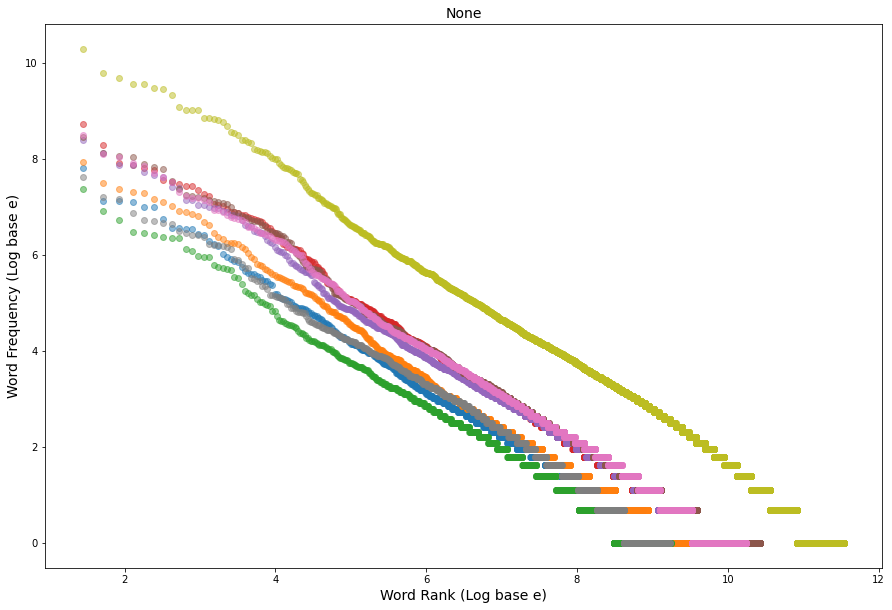

-0.862180151448031 slope on 33536 unique words and 34432.13099819263 total words for all_french_books
('de', 27320)
434
-1.0210488710413286


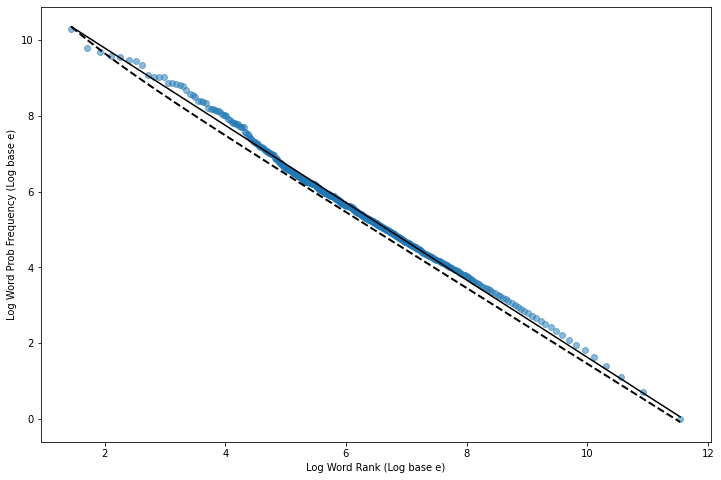

33537
-1.0362467658280632


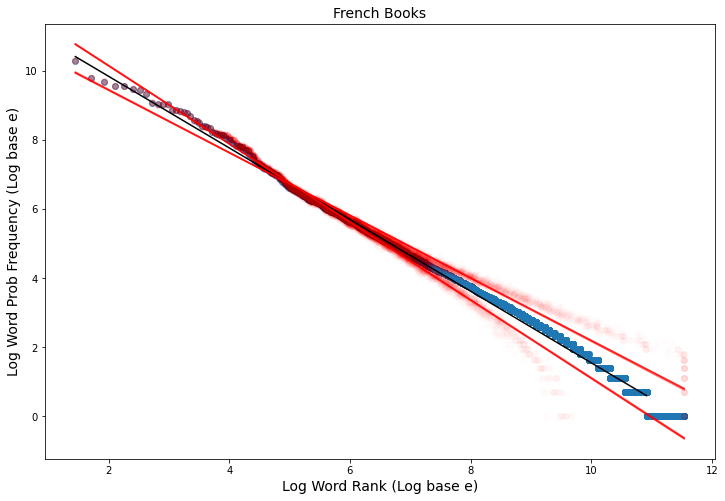

-1.1299870433308181
-0.9070582825556397


In [935]:
f_book_d = create_book_dictionary('french_books')
f_book_df = new_common_df(f_book_d)
new_slope(f_book_df, f_book_d)
plot_df(f_book_df)


f_full_text = tokenize_dictionary(f_book_d)
f_combine_test = combine_books_dictionary(f_book_d, "all_french_books")
f_book_df = new_common_df(f_combine_test,90000)
new_slope(f_book_df, f_combine_test,"yes")
f_full_text = tokenize_dictionary(f_combine_test)
f_expected_df = zipf_df(f_full_text,f_book_df)
plot_exp_df(f_book_df, f_expected_df)

f_full_text = create_book_dictionary('french_books')
f_justwords = dictionary_to_token(f_full_text)
f_r_dict = ranked_dictionary(f_justwords)
f_justwords = dictionary_to_token(f_combine_test)
f_r_dict = ranked_dictionary(f_justwords)
f_array_check = random_corpus(f_justwords, f_combine_test, 25)

plot_rand(f_book_df, f_array_check['all_french_books'],"French Books")

13023
195743
7647
130607
13023


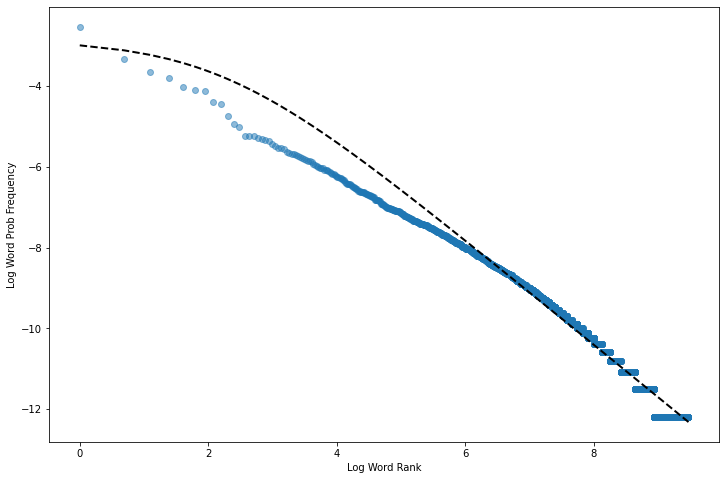

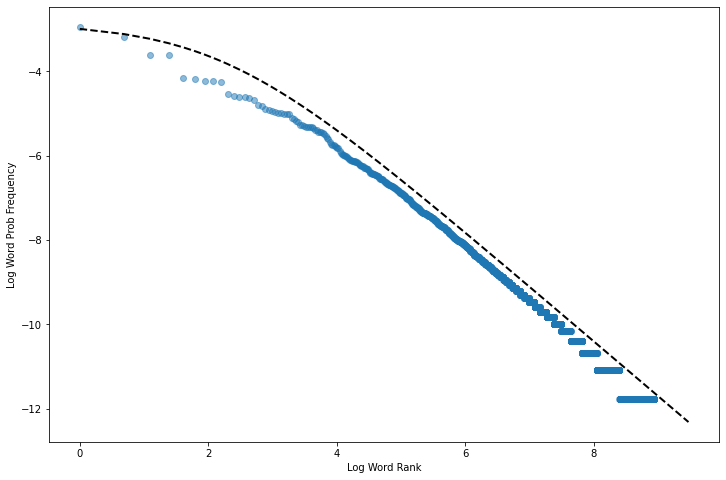

In [354]:
g_book_d = create_book_dictionary('greek_books')
g_book_df = new_common_df(g_book_d)
new_slope(g_book_df, g_book_d)
#plot_df(g_book_df)
full_text = tokenize_dictionary(g_book_d)
expected_df = zipf_df(full_text,g_book_df)
plot_exp_df(g_book_df, expected_df)

-0.7577228441143655 slope on 4519 unique words and 13218 total words for Ciceros_Orations_by_Cicero
-0.9209947162775061 slope on 4703 unique words and 20528 total words for Meditationes_de_prima_philosophia_by_René_Descartes
-0.578510701395389 slope on 8276 unique words and 17012 total words for Odes_and_Epodes_by_Horace
-0.8757689889710972 slope on 16637 unique words and 63802 total words for The_Aeneid_by_Virgil


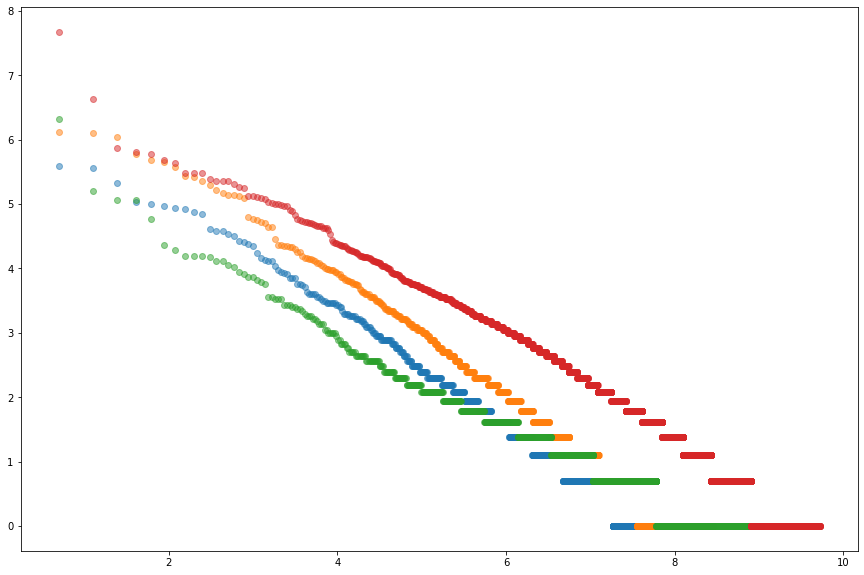

In [51]:
l_book_d = create_book_dictionary('latin_books')
l_book_df = new_common_df(l_book_d)
new_slope(l_book_df, l_book_d )
plot_df(l_book_df)

3270
16015
9417
100285
3270


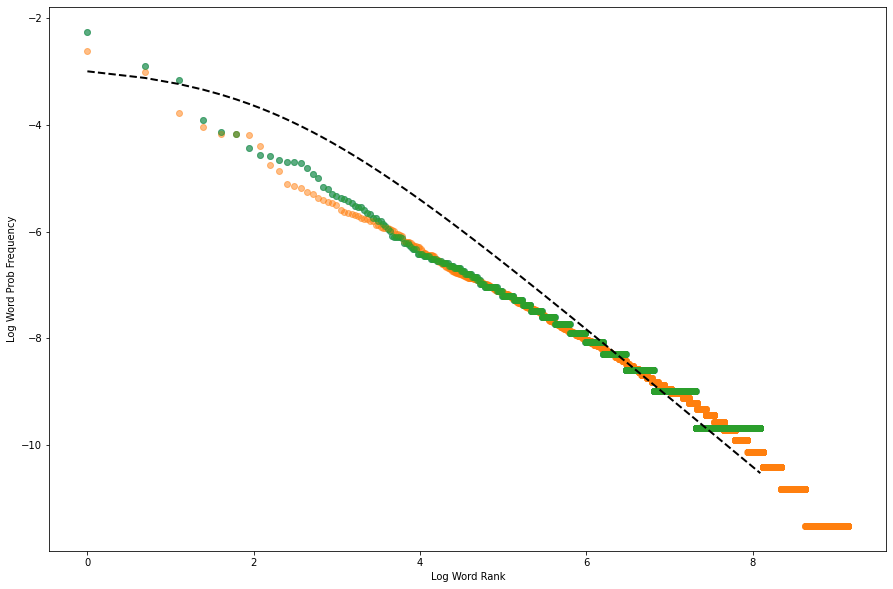

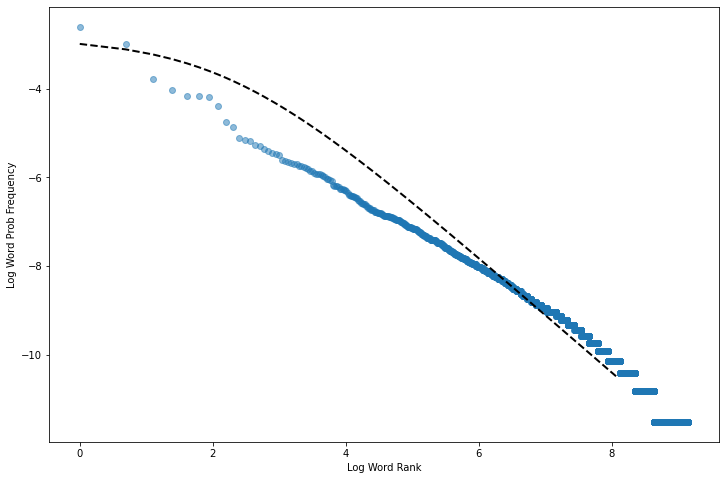

In [351]:
le_book_d = create_book_dictionary('latin_english_books')
le_book_df = new_common_df(le_book_d)
new_slope(le_book_df, le_book_d)
plot_df(le_book_df)
le_full_text = tokenize_dictionary(le_book_d)
le_expected_df = zipf_df(le_full_text,le_book_df)
plot_exp_df(le_book_df, le_expected_df)

-1.1951165882340564 slope on 825 unique words and 6439 total words for Cat_in_the_Hat_Dr_Seuss
-1.3162671447385936 slope on 51 unique words and 809 total words for Green_Eggs_and_Ham_by_Dr_Seuss


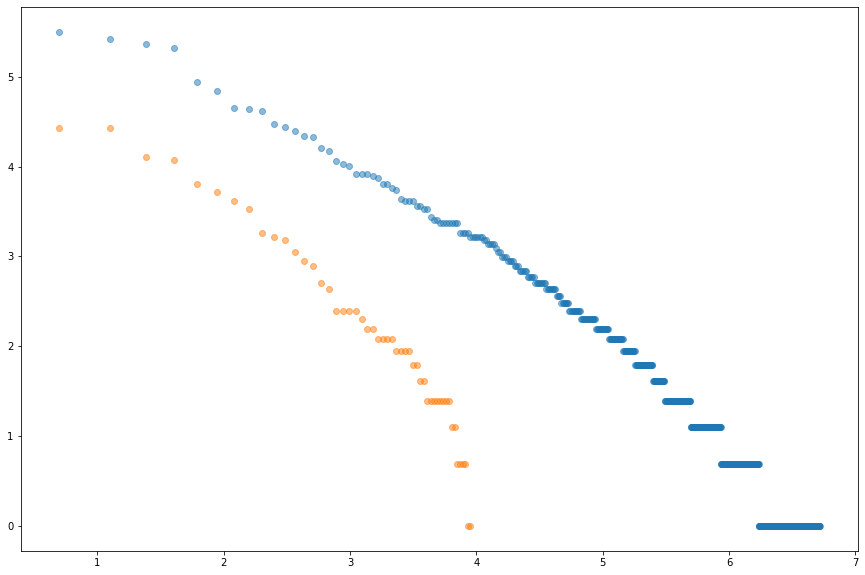

In [29]:
seuss_book_d = full_book_dictionary('seuss_books')
seuss_book_df = new_common_df(seuss_book_d)
new_slope(seuss_book_df, seuss_book_d)
plot_df(seuss_book_df)

In [30]:
seuss_dictionary = tokenize_dictionary(seuss_book_d)

{'Cat_in_the_Hat_Dr_Seuss': ['The',
  'Cat',
  'in',
  'the',
  'Hat',
  'By',
  'Dr',
  'Seuss',
  'The',
  'sun',
  'did',
  'not',
  'shine',
  'It',
  'was',
  'too',
  'wet',
  'to',
  'play',
  'So',
  'we',
  'sat',
  'in',
  'the',
  'house',
  'All',
  'that',
  'cold',
  'cold',
  'wet',
  'day',
  'I',
  'sat',
  'there',
  'with',
  'Sally',
  'We',
  'sat',
  'there',
  'we',
  'two',
  'And',
  'I',
  'said',
  'How',
  'I',
  'wish',
  'We',
  'had',
  'something',
  'to',
  'do',
  'Too',
  'wet',
  'to',
  'go',
  'out',
  'And',
  'too',
  'cold',
  'to',
  'play',
  'ball',
  'So',
  'we',
  'sat',
  'in',
  'the',
  'house',
  'We',
  'did',
  'nothing',
  'at',
  'all',
  'So',
  'all',
  'we',
  'could',
  'do',
  'was',
  'to',
  'Sit',
  'Sit',
  'Sit',
  'Sit',
  'And',
  'we',
  'did',
  'not',
  'like',
  'it',
  'Not',
  'one',
  'little',
  'bit',
  'BUMP',
  'And',
  'then',
  'something',
  'went',
  'BUMP',
  'How',
  'that',
  'bump',
  'made',
  'us',


('8AM', 983)
        rank_log  voynich_script
0       1.317222       -3.555487
1       1.558077       -4.250275
2       1.752291       -4.317842
3       1.915031       -4.392622
4       2.055089       -4.397338
...          ...             ...
1091    7.045782       -9.097198
1437    7.322297       -9.386835
2233    7.765158       -9.795055
6769    8.880583      -10.492911
89999  11.485099             NaN

[125 rows x 2 columns]


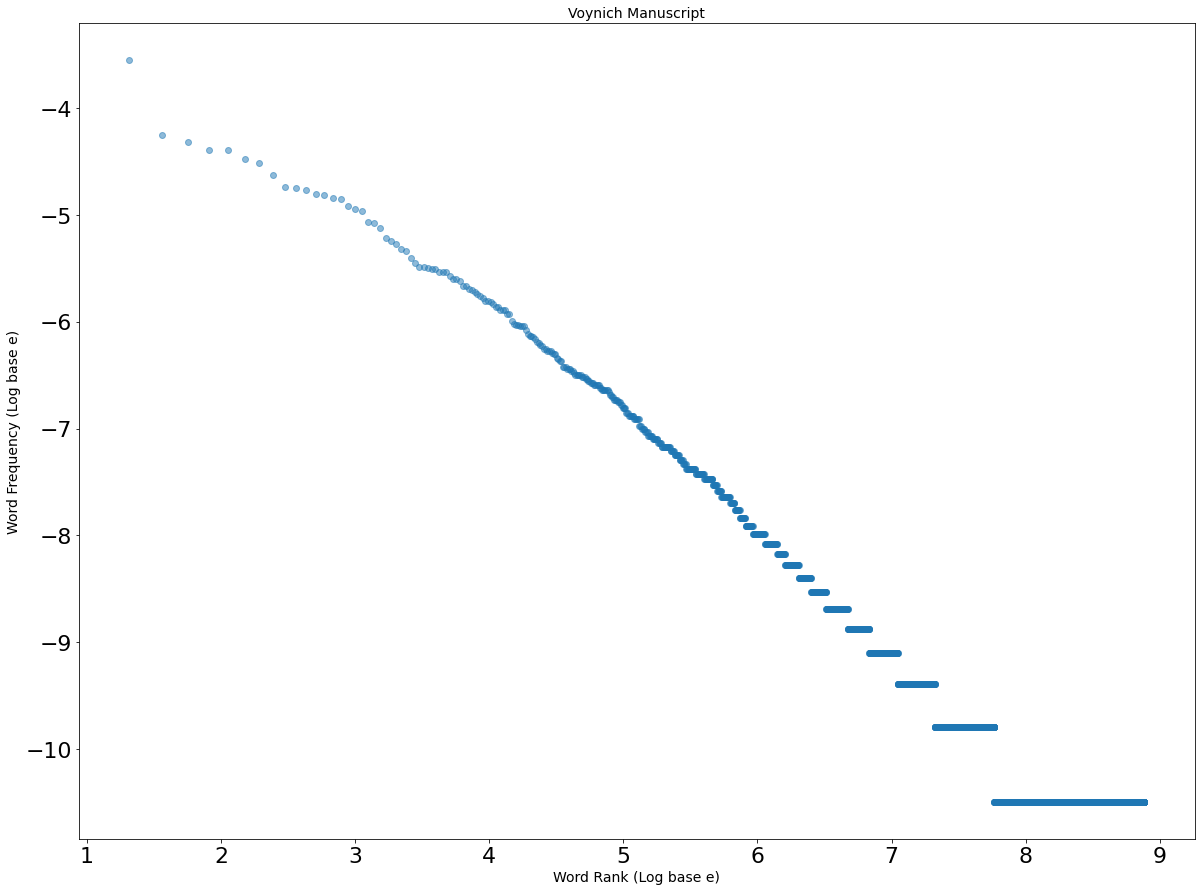

-0.9761373349989623 slope on 6769 unique words and -67458.65941742198 total words for voynich_script
        rank_log  all_english_books
0       1.448944          -2.953062
1       1.713884          -3.412601
2       1.927520          -3.622185
3       2.106534          -3.656202
4       2.260597          -3.861878
...          ...                ...
26352  11.273460         -13.956567
30738  11.443939         -14.246204
38575  11.695425         -14.654424
63347  12.244715         -15.352280
89999  12.633609                NaN

[1115 rows x 2 columns]


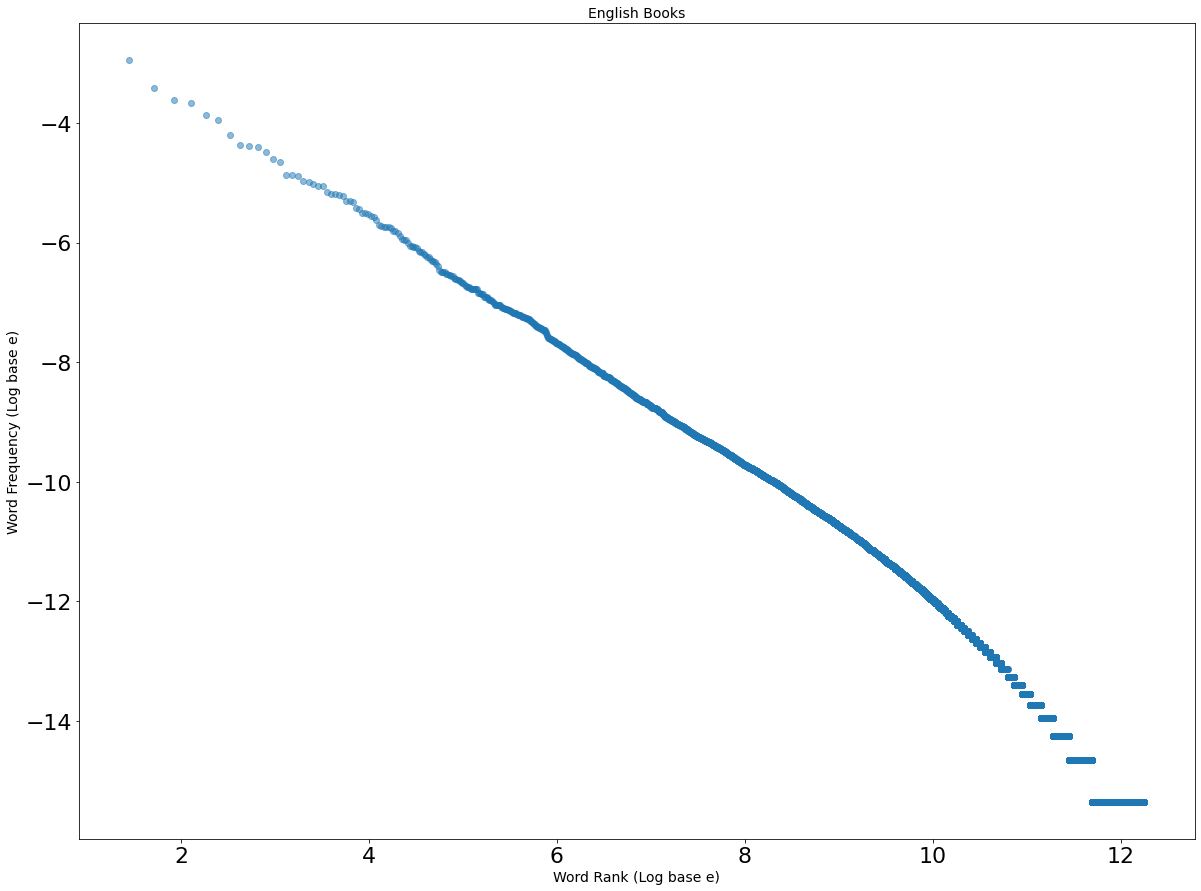

-0.664670390347787 slope on 63347 unique words and -883970.7163642403 total words for all_english_books
        rank_log  voynich_script
0       1.317222       -3.555487
1       1.558077       -4.250275
2       1.752291       -4.317842
3       1.915031       -4.392622
4       2.055089       -4.397338
...          ...             ...
1091    7.045782       -9.097198
1437    7.322297       -9.386835
2233    7.765158       -9.795055
6769    8.880583      -10.492911
89999  11.485099             NaN

[125 rows x 2 columns]
-0.9761373349989623 slope on 6769 unique words and -67458.65941742198 total words for voynich_script
        rank_log  all_english_books
0       1.448944          -2.953062
1       1.713884          -3.412601
2       1.927520          -3.622185
3       2.106534          -3.656202
4       2.260597          -3.861878
...          ...                ...
26352  11.273460         -13.956567
30738  11.443939         -14.246204
38575  11.695425         -14.654424
63347  12.24471

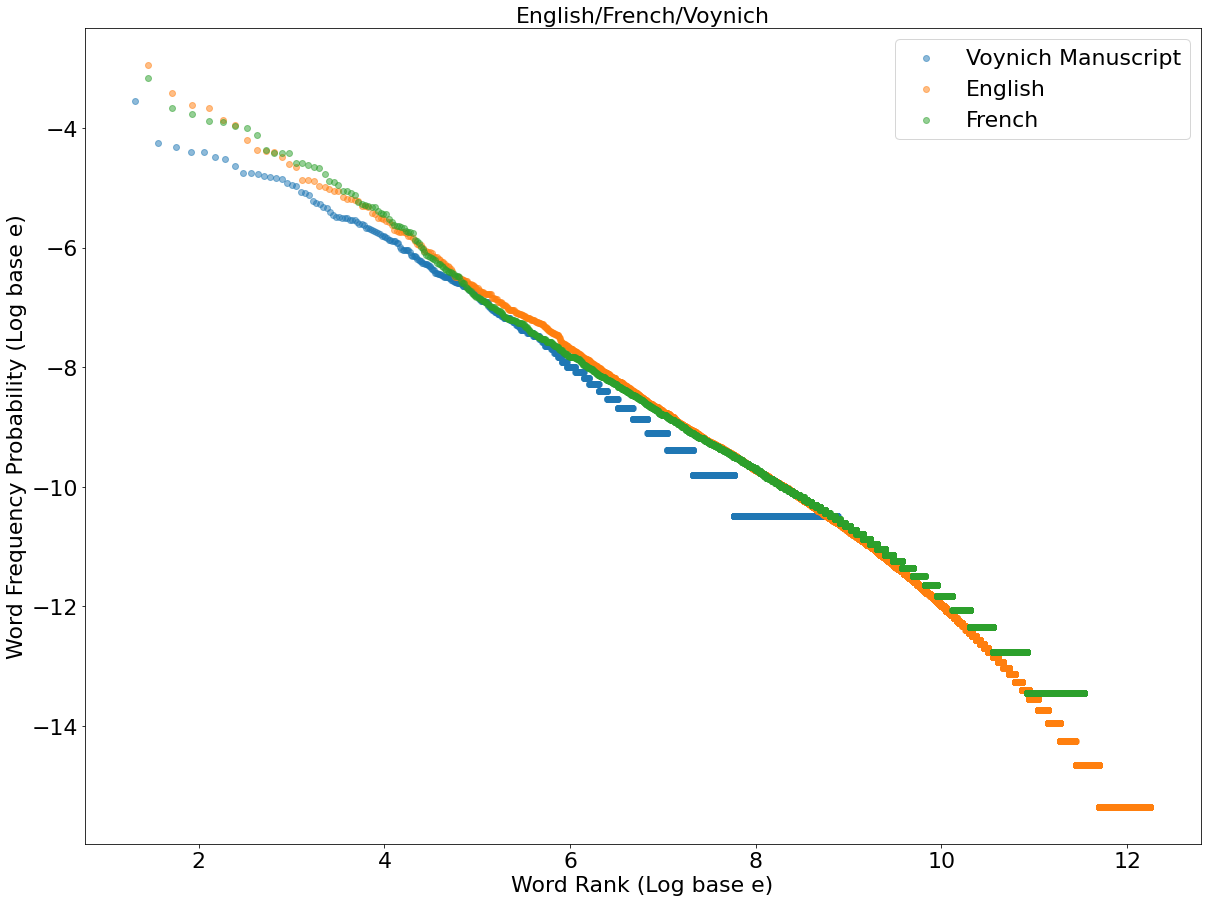

In [1613]:
#manuscript_book_d = full_book_dictionary('manuscript_text')
manuscript_book_d = voynich_cleaner()
manuscript_df = full_common_df(manuscript_book_d)
#pfit_slope(manuscript_df)
#print(manuscript_df.head())
m_full_text = tokenize_dictionary(manuscript_book_d)
m_expected_df = zipf_df(m_full_text, manuscript_df)
#plot_exp_df(manuscript_df, m_expected_df)
new_slope(manuscript_df, m_expected_df, "yes","Voynich Manuscript")


manuscript_words = dictionary_to_token(manuscript_book_d)
manuscript_r_dict = ranked_dictionary(manuscript_words)
#list(justwords.keys())[0]
array_check = random_corpus(manuscript_words, manuscript_book_d, 50)
#print(array_check)
#print(array_check['A Christmas Carol in Prose; Being a Ghost Story of Christmas by Charles Dickens'])
#print(justwords['A Christmas Carol in Prose; Being a Ghost Story of Christmas by Charles Dickens'])
#r_dict = ranked_dictionary(justwords)
#list(justwords.keys())[0]
#array_check = random_corpus(justwords, combine_test, 25)
#plot_rand(manuscript_df, array_check['voynich_script'],"Voynich Manuscript")

e_book_d = create_book_dictionary('english_books')
#e_book_df = new_common_df(e_book_d)
#new_slope(e_book_df, e_book_d)
#full_text = tokenize_dictionary(e_book_d)
combine_test = combine_books_dictionary(e_book_d, "all_english_books")
e_book_df = new_common_df(combine_test,90000)
new_slope(e_book_df, combine_test,"yes", "English Books")


f_book_d = create_book_dictionary('french_books')
f_book_df = new_common_df(f_book_d)

f_full_text = tokenize_dictionary(f_book_d)
f_combine_test = combine_books_dictionary(f_book_d, "all_french_books")
f_book_df = new_common_df(f_combine_test,90000)


c_new_slope(manuscript_df, e_book_df, f_book_df, "yes", "English/French/Voynich")

In [1612]:
def c_new_slope(fit_df, next_g, french_graph, graph_check = "no", graph_label = "None"):
    plt.rcParams.update({'font.size': 22})
    form_fit_df = fit_df.apply(pd.to_numeric)
    count = 0
    if graph_check == "yes":
        for col in fit_df.columns:
            if count == 1:
                form_fit_df = form_fit_df.drop_duplicates(subset=[col], keep='last')
                print(form_fit_df)
            count = count + 1
    count = 0
    form_fit_df = fit_df
    for col in fit_df.columns:
        row_len = form_fit_df[col].count() -1
        if count != 0:
            total_words = fit_df[col].sum()
            theta = np.polyfit(form_fit_df.iloc[:row_len,count], form_fit_df.iloc[:row_len,0], 1)
            if graph_check == "yes":
                plt.scatter(form_fit_df.iloc[:,0], form_fit_df.iloc[:,count], alpha=.5, label = 'Voynich Manuscript')
                plt.xlabel("Word Rank (Log base e)",size=22)
                plt.ylabel("Word Frequency (Log base e)",size=22)
                plt.title(graph_label,size=22)
                print("{} slope on {} unique words and {} total words for {}".format(theta[0],row_len,total_words,col))
        count = count + 1
        form_fit_df = fit_df.apply(pd.to_numeric)
        
    count = 0
    if graph_check == "yes":
        for col in next_g.columns:
            if count == 1:
                form_fit_df = next_g.drop_duplicates(subset=[col], keep='last')
                print(form_fit_df)
            count = count + 1
    count = 0
    form_fit_df = next_g
    for col in next_g.columns:
        row_len = next_g[col].count() -1
        if count != 0:
            total_words = next_g[col].sum()
            theta = np.polyfit(form_fit_df.iloc[:row_len,count], form_fit_df.iloc[:row_len,0], 1)
            if graph_check == "yes":
                plt.scatter(next_g.iloc[:,0], next_g.iloc[:,count], alpha=.5, label = "English")
                plt.xlabel("Word Rank (Log base e)",size=22)
                plt.ylabel("Word Frequency Probability (Log base e)",size=22)
                plt.title(graph_label,size=22)
                print("{} slope on {} unique words and {} total words for {}".format(theta[0],row_len,total_words,col))
        count = count + 1
    
    count = 0
    if graph_check == "yes":
        for col in french_graph.columns:
            if count == 1:
                form_fit_df = french_graph.drop_duplicates(subset=[col], keep='last')
                print(form_fit_df)
            count = count + 1
    count = 0
    form_fit_df = french_graph
    for col in french_graph.columns:
        row_len = french_graph[col].count() -1
        if count != 0:
            total_words = french_graph[col].sum()
            if graph_check == "yes":
                plt.scatter(french_graph.iloc[:,0], french_graph.iloc[:,count], alpha=.5, label = "French")
        count = count + 1
    
    plt.xlabel("Word Rank (Log base e)",size=22)
    plt.ylabel("Word Frequency Probability (Log base e)",size=22)
    plt.title(graph_label,size=22)
    plt.legend(loc='upper right')
    plt.show()

In [950]:
print(manuscript_r_dict)

{'voynich_script': [('8am', 983), ('tc8g', 493), ('4odam', 461), ('oe', 428), ('sc8g', 426), ('toe', 394), ('am', 379), ('tcg', 339), ('4odcc8g', 302), ('odam', 299), ('8ar', 295), ('4odccg', 284), ('or', 281), ('scg', 274), ('4odc8g', 270), ('8ae', 255), ('ar', 247), ('2am', 242), ('oham', 220), ('tor', 216), ('8g', 208), ('4odae', 189), ('soe', 183), ('ae', 178), ('4oe', 170), ('tccg', 167), ('tcoe', 157), ('odccg', 149), ('tdzg', 144), ('4odar', 144), ('4odg', 143), ('2', 141), ('t8g', 141), ('tg', 138), ('dam', 138), ('ohc8g', 137), ('sccg', 133), ('4oham', 129), ('ohae', 129), ('odae', 127), ('ram', 121), ('ohar', 121), ('so', 118), ('etc8g', 116), ('hzg', 114), ('odar', 112), ('4odcg', 110), ('odc8g', 108), ('sg', 105), ('scoe', 105), ('8oe', 104), ('odcc8g', 102), ('8an', 99), ('8air', 99), ('ohccg', 97), ('ohg', 97), ('4ohc8g', 97), ('sor', 93), ('8ak', 93), ('4odoe', 87), ('ohcc8g', 85), ('odg', 84), ('2oe', 84), ('to8g', 83), ('4ohg', 83), ('tcor', 83), ('scc8g', 80), ('2ar',

In [1000]:
def topic_calc(rank_dict, all_text):
    total_u_words = len(rank_dict)
    count = 0 
    for x in rank_dict:
        if x[1] == 1:
            break
        count = count + 1
    print(count)
    print(total_u_words)
    print(int(total_u_words/4))
    rare_words = []
    total_rare = 10
    for x in range(total_rare):
        rare_words.append(rank_dict[count-x][0])
    rev_text = all_text[::-1]
    for r in rare_words:
        first_app = all_text.index(r)
        last_app = len(all_text) - 1 - rev_text.index(r)
        topic_dist = last_app - first_app
        print(topic_dist)
        #mylist.index(item)

2237
6774
1693
12431


In [1022]:
print(manuscript_r_dict['voynich_script'][2236])
m_full_text['voynich_script'][::-1].index('EK')

('ek', 2)


272

In [89]:
new_df = script_test(manuscript_book_d)
new_corpus = spilt_corpus(new_df)
print(new_corpus)

       xg     yg
0     485  484.0
1     257  241.0
2     208  231.0
3     207  224.0
4     198  228.0
...   ...    ...
7379    0    1.0
7380    1    0.0
7381    1    0.0
7382    1    0.0
7383    1    0.0

[7384 rows x 2 columns]


In [321]:
print(np.random.binomial(10, .5, 1)[0])
print(manuscript_book_d)

4
{'voynich_script': '#\n#\n#\n#\n#\n#\n#\n#\n\x0c\n#\nFGAG2,GDAE,AR,GHAM,SOE,SORG,0D0RC2,GDOR,SOE8G-\n2ORG,DZAR,ORG,DAIR,THAM,SOR,AR,HZAR,HZAR,8ALA-\n2GAIIR,SCDG,OR,GDAM,SO8,HZOARG,HZC2,8ARAM,2G-\n0OM,OHCCG,OHCAR,ROEOHG,HZAAR,8AM,ODAM,OR,ODAL-\n2AIRG,TCAR,HZAM,PZAR,FZAM=\nG8ARAISG=\nO8AR,SG,SOE,PZOG,OG8AR,S,2,FZOAM,SO8ARG-\nGSCG,SO8G,ODTO,G,OHTOE,TOHZG,O2TG,8AN,TOR,DO2-\n8AM,SOR,FZOE,SO8G=\n8AN,02,HCO8G=\nG8AN,PZC2AM,OE2,PZCG,GHAN,SOSG,PZO8AEC2-\nODSO,DSOG,OHAIRN,OHCOE,ODAL,SO8AN,2DZCG,8AM-\nSOG,DZCG,DO8AM,PZG,PZ08AIIE2,HZCG,SC,OE8AN,8-\n8AN,OM,TOE,O8AM,TO8AN,T8G,ODON,80R,HZG,DO8-\n8AM,SDZCG,DZOR,TOR,SCG,DOE,TOE,TOE,DOR,TOE-\nSO,TOE,SO8AL,DSG,DTG,8OR,TO8AM,SO,DOCAK-\nGTO,HTCG,TCDAN,SCO,PSOE,8G8G8,HZG,8AIHZG-\nGHO,SOE,SC,DO8SCG,PZCAEG,8ARAN,8AN,DZG82-\n8TAR,SHZAM,ODAIIR,TCG,2TG,PZHOE,HZOE2,8AOCHA-\nSOD,TOR,TCG,8AN,DZCG=\nOHOE,8AIM=\nPZO,SAM,SODTCCG,TOE,HSO8CC2G,SCG,PG8CCG,TG,RO8-\n00ON,TOE,8AN,HZAE,8AR,SCAR,DAM,8AR,SCG,HZCAR-\nCTO00,DAM,SOAM,ODOE,8AM,FAR,HZOE,8AM,HZOE8AR-\nGTCCG,ODCCG,

In [86]:
def script_test(book_d_test):
    column_name_list = list((range(1, 90000 + 1)))
    
    log_name_list = []
    for r in column_name_list:
        log_name_list.append(math.log(r))
    
    column_name = ['rank_log']
    cmn_word_df = pd.DataFrame(columns=column_name)
    cmn_word_df['rank_log']= log_name_list
    #cmn_word_df.loc[0,:] = log_name_list
    
    count = 0
    book_index = []
    for b in book_d_test:
        word_rank = 0 
        false_word = ['s','t','n','5','10','15','20']
        ind = []
        fre = []
        fretwo = []
        book_df_header = [b]
        single_book_df = pd.DataFrame(columns=book_df_header)
        run = 1
        book_token_words = [x.lower() for x in regexp_tokenize(book_d_test[b], '\w+')]
        if len(book_token_words) > 0:
            book_index.append(b)
            book_token_counter = Counter(book_token_words).most_common()
            max_fre = 0
            for item in book_token_counter:
                if item[0] not in false_word:
                    ind.append(item[0])
                    fre.append(item[1])
                    fretwo.append(math.log(item[1]))
                    if (item[1]*run) > max_fre:
                        max_fre = item[1]*run
                    run = run + 1
                    word_rank = word_rank + 1
            single_book_df[b] = fre
            cmn_word_df = pd.concat([cmn_word_df,single_book_df], axis=1)
            #cmn_word_df.loc[count+1,:] = fretwo
            count = count + 1
    return(cmn_word_df)

In [70]:
plt.rcParams["figure.figsize"] = [20, 15]
count = 0
for row in word_df.iterrows():
    if count != 0:
        plt.plot(word_df.loc[0,:], word_df.loc[count,:], alpha=.5, linewidth='4')
    count = count + 1

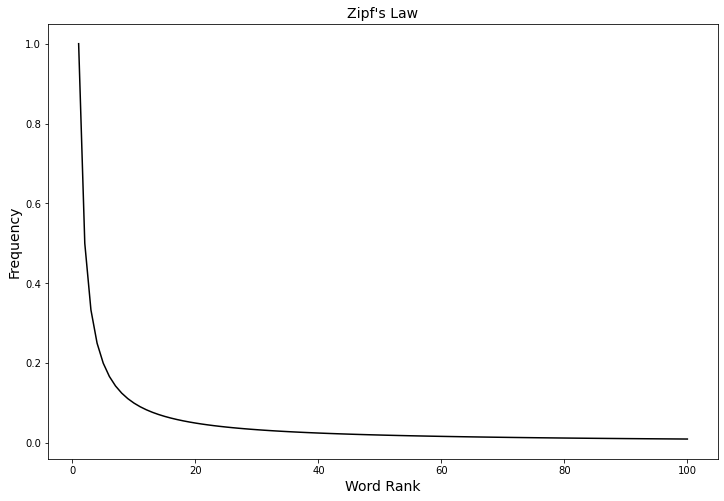

In [890]:
runs = 100
x_list = []
y_list = []
for r in range(runs):
    x_list.append(r+1)
    new_y = (1/(1+r))
    y_list.append(new_y)
plt.plot(x_list, y_list, '-', color='black')
plt.xlabel('Word Rank', size = 14)
plt.ylabel('Frequency', size = 14)
plt.title("Zipf's Law", size = 14)
plt.show()

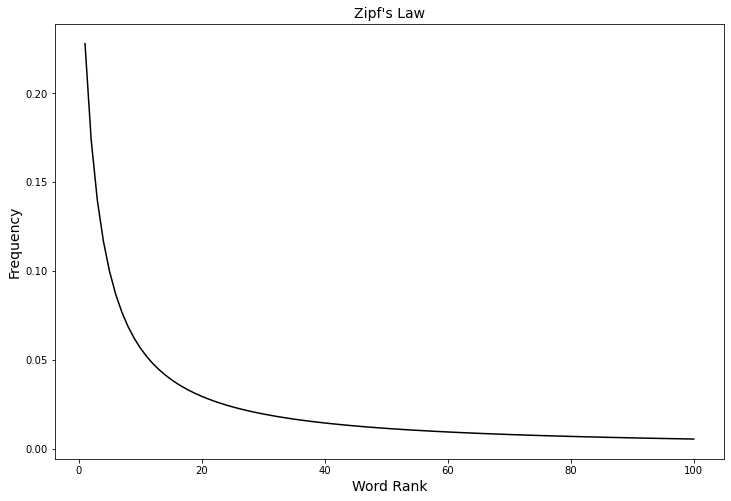

In [897]:
runs = 100
x_list = []
y_list = []
for r in range(runs):
    x_list.append(r+1)
    new_y = (1/(3.7+r)**1.13)
    y_list.append(new_y)
plt.plot(x_list, y_list, '-', color='black')
plt.xlabel('Word Rank', size = 14)
plt.ylabel('Frequency', size = 14)
plt.title("Zipf's Law", size = 14)
plt.show()

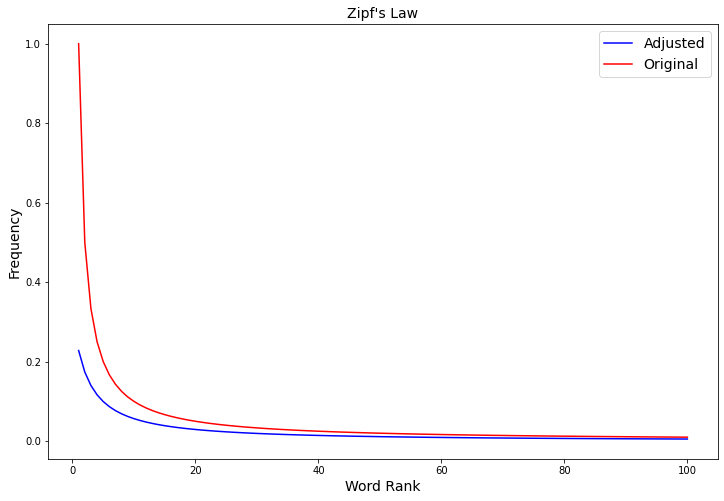

In [903]:
runs = 100
x_list = []
y_list = []
for r in range(runs):
    x_list.append(r+1)
    new_y = (1/(3.7+r)**1.13)
    y_list.append(new_y)
plt.plot(x_list, y_list, '-', color='blue',label='Adjusted')

runs = 100
x_list = []
y_list = []
for r in range(runs):
    x_list.append(r+1)
    new_y = (1/(1+r))
    y_list.append(new_y)
plt.plot(x_list, y_list, '-', color='red',label="Original")


plt.xlabel('Word Rank', size = 14)
plt.ylabel('Frequency', size = 14)
plt.title("Zipf's Law", size = 14)
plt.legend(loc='upper right', fontsize = 14)
plt.show()